# Fitting DC2 v2 Simulation Data with MultiProFit

This notebook plots results from fitting sources from the Vera Rubin Observatory/LSST Dark Energy Science Collaboration (DESC, https://lsstdesc.org/) DC2 simulations (http://lsstdesc.org/DC2-production/) using MultiProFit (https://github.com/lsst-dm/multiprofit, 'MPF'). Specifically, it reads the results of using a Task to fit exposures given an existing catalog with fits from meas_modelfit (https://github.com/lsst/meas_modelfit, 'MMF'). MMF implements a variant of the SDSS CModel algorithm (https://www.sdss.org/dr12/algorithms/magnitudes/#cmodel). In additional to CModel, MultiProFit allows for multi-band fitting, as well as fitting of Sersic profiles, multi-Gaussian approximations thereof ('MG' Sersic), and non-parametric radial profiles (Gaussian mixtures model with shared ellipse parameters, effectively having a Gaussian mixture radial profile). Thus, the main results are comparisons of the two codes doing basically the same thing (single-band exponential, de Vaucouleurs, and CModel linear combination fits), followed by plots highlighting Sersic vs CModel fits, more complicated double Sersic/free-amplitude models, and MultiProFit's multi-band fits.

In [1]:
# Import requirements
import functools
import lsst.daf.butler as dafButler
import matplotlib as mpl
import matplotlib.pyplot as plt
import modelling_research.dc2 as dc2
import modelling_research.meas_model as mrMeas
from modelling_research.calibrate import calibrate_catalogs
from modelling_research.plotting import plotjoint_running_percentiles
from modelling_research.plot_matches import plot_matches
import numpy as np
import os
import seaborn as sns

In [2]:
# Setup for plotting
%matplotlib inline
sns.set_style('darkgrid')
mpl.rcParams['figure.dpi'] = 160
mpl.rcParams['image.origin'] = 'lower'
sns.set(rc={'axes.facecolor': '0.85', 'figure.facecolor': 'w'})

In [3]:
# Catalog matching settings
# Reference band to match on. Should be 'r' for DC2 because reasons (truth refcats are r mag limited)
band_ref = 'r'

In [4]:
# Load the truth catalogs and count all of the rows
butler_ref = dc2.get_refcat(make=False)

/home/dtaranu/src/mine/modelling_research/dc2.py:60: FutureWarning: Gen2 Butler has been deprecated (Butler). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  butler = Butler(refcat_path)
/home/dtaranu/src/mine/modelling_research/dc2.py:60: FutureWarning: Gen2 Butler has been deprecated (ImsimMapper). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  butler = Butler(refcat_path)


In [5]:
# Load the DC2 repo butlers: we'll need them later
butlers_dc2 = {
    '2.2i': dafButler.Butler('/repo/dc2', collections='2.2i/runs/test-med-1/w_2021_04/DM-28453'),
}
butler_dc2 = butlers_dc2['2.2i']

In [6]:
# Match with the refcat using astropy's matcher
truth_path = dc2.get_truth_path()
tract = 3828
tracts = {tract: ('/project/dtaranu/dc2_gen3/w_2021_04_gen2to3_multibandfit/calcats/', '2.2i')}
filters_single = ('g', 'r', 'i', 'z')
filters_multi = ()
band_multi = None
name_skymap = 'DC2'
skymap = butler_dc2.get('skyMap', name=name_skymap)

# Regex to read files
get_path_cats = functools.partial(dc2.get_path_cats, patches_regex='*')

# Calibrate catalogs: this only needs to be done once; get_cmodel_forced should only be true for single bands for reasons
calibrate_cats = True
get_multiprofit = False
get_cmodel_forced = True
get_ngmix = False
get_scarlet = False

if calibrate_cats:
    patch_begin_x, patch_end_x, patch_begin_y, patch_end_y = 0, 6, 0, 6
    patch_max_x, patch_max_y = skymap[tract].getNumPatches()
    skip_existing = True
    butler_scarlet = butler_dc2 if get_scarlet else None
    path = tracts[tract][0]
    for bands in filters_multi + filters_single:
        butler_ngmix = butler_dc2 if get_ngmix else None
        is_single = len(bands) == 1
        path_band = f'{path}{bands}'
        if not os.path.isdir(path_band):
            os.mkdir(path_band)
        files = [
            f'{path_band}/mpf_dc2_{bands}_3828_{x + patch_max_x*y}.fits'
            for x in range(patch_begin_x, patch_end_x + 1) for y in range(patch_begin_y, patch_end_y + 1)
        ]
        if skip_existing:
            files = [f for f in files if not os.path.isfile(f'{f.split(".fits")[0]}_mag.fits')]
        if files:
            print(f'Calibrating: files')
            calibrate_catalogs(
                files, butlers_dc2, is_dc2=True, use_butler=True, files_ngmix=butler_ngmix,
                butler_scarlet=butler_scarlet, get_cmodel_forced=get_cmodel_forced and is_single,
                overwrite_band=None, datasetType='deepCoadd_meas',
            )
cats = dc2.match_refcat_dc2(
    butler_ref, match_afw=False, tracts=tracts, butlers_dc2=butlers_dc2,
    filters_single=filters_single, filters_multi=filters_multi, func_path=get_path_cats,
    kwargs_get={'skymap': 'DC2'},
)

Loading tract 3828 band r
Loading 49 files from path=/project/dtaranu/dc2_gen3/w_2021_04_gen2to3_multibandfit/calcats/r/mpf_dc2_r_3828_*_mag.fits
Loaded in 13.0s; loading 0 (1/49) and matching file=/project/dtaranu/dc2_gen3/w_2021_04_gen2to3_multibandfit/calcats/r/mpf_dc2_r_3828_0_mag.fits; len(cat,truth)=11688,109327
Loaded in 48.3s; loading 10 (2/49) and matching file=/project/dtaranu/dc2_gen3/w_2021_04_gen2to3_multibandfit/calcats/r/mpf_dc2_r_3828_10_mag.fits; len(cat,truth)=27399,211408
Loaded in 46.5s; loading 11 (3/49) and matching file=/project/dtaranu/dc2_gen3/w_2021_04_gen2to3_multibandfit/calcats/r/mpf_dc2_r_3828_11_mag.fits; len(cat,truth)=43771,316412
Loaded in 19.6s; loading 12 (4/49) and matching file=/project/dtaranu/dc2_gen3/w_2021_04_gen2to3_multibandfit/calcats/r/mpf_dc2_r_3828_12_mag.fits; len(cat,truth)=59359,418668
Loaded in 18.6s; loading 13 (5/49) and matching file=/project/dtaranu/dc2_gen3/w_2021_04_gen2to3_multibandfit/calcats/r/mpf_dc2_r_3828_13_mag.fits; len(

Loaded in 21.6s; loading 7 (47/49) and matching file=/project/dtaranu/dc2_gen3/w_2021_04_gen2to3_multibandfit/calcats/r/mpf_dc2_r_3828_7_mag.fits; len(cat,truth)=704246,4900582
Loaded in 19.5s; loading 8 (48/49) and matching file=/project/dtaranu/dc2_gen3/w_2021_04_gen2to3_multibandfit/calcats/r/mpf_dc2_r_3828_8_mag.fits; len(cat,truth)=720947,5004844
Loaded in 20.1s; loading 9 (49/49) and matching file=/project/dtaranu/dc2_gen3/w_2021_04_gen2to3_multibandfit/calcats/r/mpf_dc2_r_3828_9_mag.fits; len(cat,truth)=738754,5111088
Loading tract 3828 band g
Loading 49 files from path=/project/dtaranu/dc2_gen3/w_2021_04_gen2to3_multibandfit/calcats/g/mpf_dc2_g_3828_*_mag.fits
Loaded in 3.0s; loading 0 (1/49) file=/project/dtaranu/dc2_gen3/w_2021_04_gen2to3_multibandfit/calcats/g/mpf_dc2_g_3828_0_mag.fits; len(cat,truth)=11688,5111088
Loaded in 2.7s; loading 10 (2/49) file=/project/dtaranu/dc2_gen3/w_2021_04_gen2to3_multibandfit/calcats/g/mpf_dc2_g_3828_10_mag.fits; len(cat,truth)=27399,5111088

Loaded in 2.1s; loading 7 (47/49) file=/project/dtaranu/dc2_gen3/w_2021_04_gen2to3_multibandfit/calcats/g/mpf_dc2_g_3828_7_mag.fits; len(cat,truth)=704246,5111088
Loaded in 1.9s; loading 8 (48/49) file=/project/dtaranu/dc2_gen3/w_2021_04_gen2to3_multibandfit/calcats/g/mpf_dc2_g_3828_8_mag.fits; len(cat,truth)=720947,5111088
Loaded in 3.1s; loading 9 (49/49) file=/project/dtaranu/dc2_gen3/w_2021_04_gen2to3_multibandfit/calcats/g/mpf_dc2_g_3828_9_mag.fits; len(cat,truth)=738754,5111088
Loading tract 3828 band i
Loading 49 files from path=/project/dtaranu/dc2_gen3/w_2021_04_gen2to3_multibandfit/calcats/i/mpf_dc2_i_3828_*_mag.fits
Loaded in 2.1s; loading 0 (1/49) file=/project/dtaranu/dc2_gen3/w_2021_04_gen2to3_multibandfit/calcats/i/mpf_dc2_i_3828_0_mag.fits; len(cat,truth)=11688,5111088
Loaded in 2.0s; loading 10 (2/49) file=/project/dtaranu/dc2_gen3/w_2021_04_gen2to3_multibandfit/calcats/i/mpf_dc2_i_3828_10_mag.fits; len(cat,truth)=27399,5111088
Loaded in 2.8s; loading 11 (3/49) file=/p

Loaded in 3.1s; loading 7 (47/49) file=/project/dtaranu/dc2_gen3/w_2021_04_gen2to3_multibandfit/calcats/i/mpf_dc2_i_3828_7_mag.fits; len(cat,truth)=704246,5111088
Loaded in 1.8s; loading 8 (48/49) file=/project/dtaranu/dc2_gen3/w_2021_04_gen2to3_multibandfit/calcats/i/mpf_dc2_i_3828_8_mag.fits; len(cat,truth)=720947,5111088
Loaded in 1.9s; loading 9 (49/49) file=/project/dtaranu/dc2_gen3/w_2021_04_gen2to3_multibandfit/calcats/i/mpf_dc2_i_3828_9_mag.fits; len(cat,truth)=738754,5111088
Loading tract 3828 band z
Loading 49 files from path=/project/dtaranu/dc2_gen3/w_2021_04_gen2to3_multibandfit/calcats/z/mpf_dc2_z_3828_*_mag.fits
Loaded in 3.0s; loading 0 (1/49) file=/project/dtaranu/dc2_gen3/w_2021_04_gen2to3_multibandfit/calcats/z/mpf_dc2_z_3828_0_mag.fits; len(cat,truth)=11688,5111088
Loaded in 2.9s; loading 10 (2/49) file=/project/dtaranu/dc2_gen3/w_2021_04_gen2to3_multibandfit/calcats/z/mpf_dc2_z_3828_10_mag.fits; len(cat,truth)=27399,5111088
Loaded in 1.9s; loading 11 (3/49) file=/p

Loaded in 2.7s; loading 7 (47/49) file=/project/dtaranu/dc2_gen3/w_2021_04_gen2to3_multibandfit/calcats/z/mpf_dc2_z_3828_7_mag.fits; len(cat,truth)=704246,5111088
Loaded in 1.8s; loading 8 (48/49) file=/project/dtaranu/dc2_gen3/w_2021_04_gen2to3_multibandfit/calcats/z/mpf_dc2_z_3828_8_mag.fits; len(cat,truth)=720947,5111088
Loaded in 2.9s; loading 9 (49/49) file=/project/dtaranu/dc2_gen3/w_2021_04_gen2to3_multibandfit/calcats/z/mpf_dc2_z_3828_9_mag.fits; len(cat,truth)=738754,5111088


## Crossmatch against reference catalog

All of the plots in this notebook compare stack measurements of sources measured by the LSST Science Pipelines cross-matched against a reference catalog that is part of the Science Pipelines repository. This reference catalog contains all sources brighter than 23 mags in r, and was generated through some kind of Task that must have read the original DC2 truth tables (more on that below).

In [7]:
# Model plot setup
# ngmix takes out a pixel scale factor of 2.5*log10(0.2**2)
# TODO: remove this offset when fixed in ngmix
offset_ngmix = -3.4948500216800937
model_specs = [
    ('PSF', 'base_PsfFlux', 1),
    ('Stack CModel', 'modelfit_CModel', 2),
]
if get_cmodel_forced:
    model_specs.append(('Forced CModel', 'modelfit_forced_CModel', 2))
if get_scarlet:
    model_specs.append(('Scarlet', 'scarlet', 0))
if get_multiprofit:
    model_specs.extend([
        ('MPF Gauss', 'multiprofit_gausspx', 1),
        ('MPF CModel', 'multiprofit_mg8cmodelpx', 2),
        ('MPF Sersic', 'multiprofit_mg8serbpx', 1),
        ('MPF Sersic Free Amp.', 'multiprofit_mg8serbapx', 8),
        #('MPF Sersic x 2', 'multiprofit_mg8serx2sepx', 2),
        #('MPF Sersic x 2 Free Amp.', 'multiprofit_mg8serx2seapx', 16),
    ])
if get_ngmix:
    model_specs.append(('ngmix bd', 'ngmix_bd', 0))

models = {
    desc: mrMeas.Model(desc, field, n_comps, mag_offset=offset_ngmix if mrMeas.is_field_ngmix(field) else None)
    for desc, field, n_comps in model_specs
}

models_stars = ['PSF', 'Stack CModel'] if get_cmodel_forced else []
if get_multiprofit:
    models_stars.extend(['MPF Gauss', 'MPF CModel', 'MPF Sersic'])
if get_ngmix:
    models_stars.append('ngmix bd')
if get_scarlet:
    models_stars.append('Scarlet')

models_stars = {model: models[model] for model in models_stars}

args = dict(scatterleft=True, scatterright=True, densityplot=sns.histplot, cmap='Reds')
args_type = {
    'resolved': {
        'limx': (14.5, 24.5),
        'limy': (-0.5, 0.5),
    },
    'unresolved': {
        'limx': (16, 23),
        'limy': (-0.08, 0.08),
    },
}
mpl.rcParams['axes.labelsize'] = 15

## Galaxy fluxes and colours

These plots show fluxes and colours for a variety of models, separately for DC2.1.1 (tract 3832) and DC2.2 (tract 3828).

Quick summary:

1. Bright and faint galaxies alike are a challenge, with large scatter in the former and a negative (model too bright) bias in the latter.
    - This is not very surprising; bright galaxies are more likely to be blended, but model mismatch shouldn't be as much of an issue here. Some kind of bias and scatter at the faint end is not surprising either, though how much and in which direction is not so clear.
2. Colours have considerably less scatter, even for single-band fits; that is, even though bright galaxies have differences much larger than expected from noise bias alone, these are about the same in each band.
    - This is somewhat encouraging if not unexpected. It's not entirely a trivial result for g-r as it is for r-i (for low redshift galaxies anyways).
3. There is at best a modest improvement from meas_modelfit (mmf) CModel to MultiProFit (mpf) CModel. The main differences here are: free centroids for mpf vs fixed in mmf; slightly different Sersic approximation (more so for dev than exp); double Gaussian vs double Shapelet PSF in mpf vs mmf (the latter ought to be better); size prior in mmf; different optimizers; analytic vs finite difference gradients in mpf vs mmf. Of all of those differences, the free centroids are most likely to provide the (modest) benefit, if any.
    - This is a more or less neutral result; I woudln't expect much difference between the two for any of the possible reasons.
4. There is a slightly more substantial improvment for single-band fluxes from CModel to Sersic; in particular, the distribution of galaxies with overestimated fluxes is tighter.
    - This is also somewhat encouraging. We know that CModel is a kludge, but it's not trivial for slightly-but-not-entirely-more-principled Sersic fits to peform better.
5. Nearly everything is improved by fitting gri simultaneously - magnitudes, colours, etc. all have tigher scatter no matter the model or band. While the improvements in one-sigma scatter for magnitudes are not necessarily large, the 2+sigma scatter is significantly tighter, as are colours.
    - This is very encouraging and non-trivial; one could have imagined galaxies with non-detections in some bands to have more biased measurements in the bands with detections, but that doesn't seem to be the case very often. Of course it's at least partly expected since the morphology of the galaxy is identical in all bands in single-component models, but the fact that this improves colours substantially without making magnitudes worse is a major bonus.

N=0 sky object matches
Rematched 6287/5100291; 456068 originally and 449646 rematched already matched
N=0sky object matches after rematching
DC2 3828 Resolved g-band, PSF, N=84844


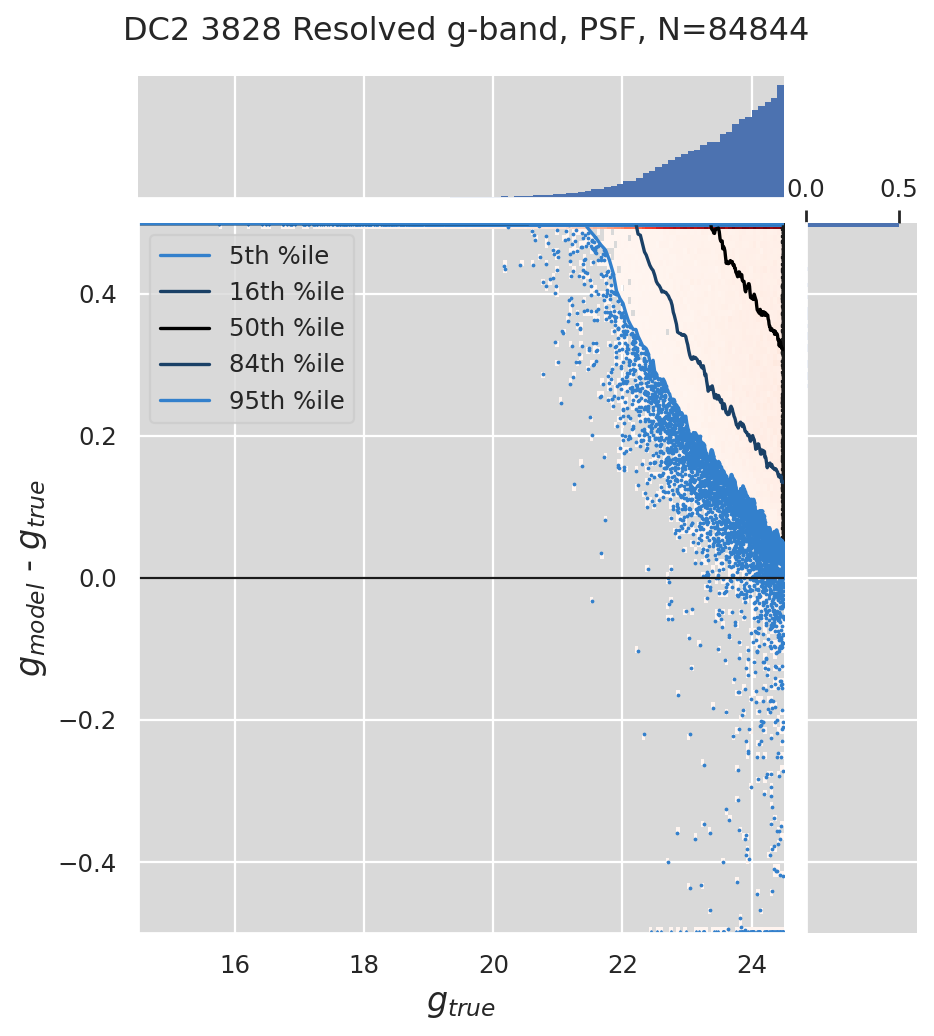

DC2 3828 Resolved r-band, PSF, N=129812


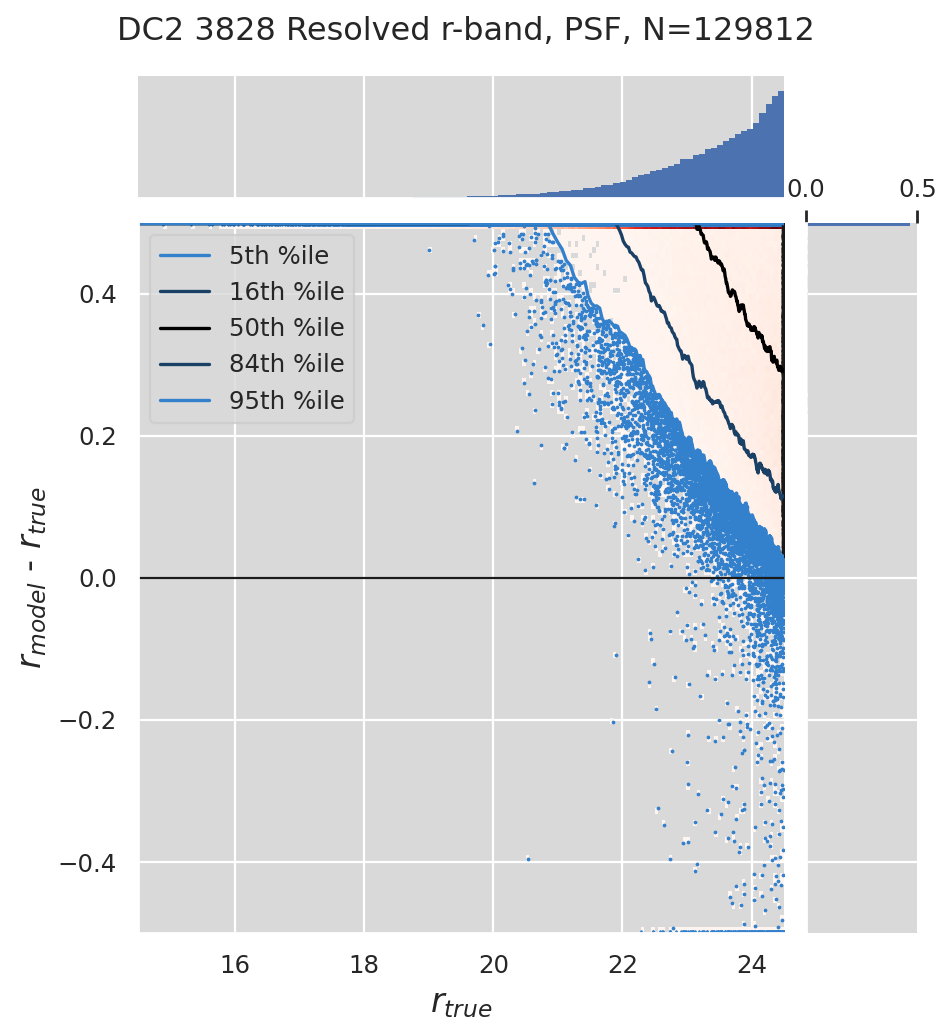

DC2 3828 Resolved i-band, PSF, N=183189


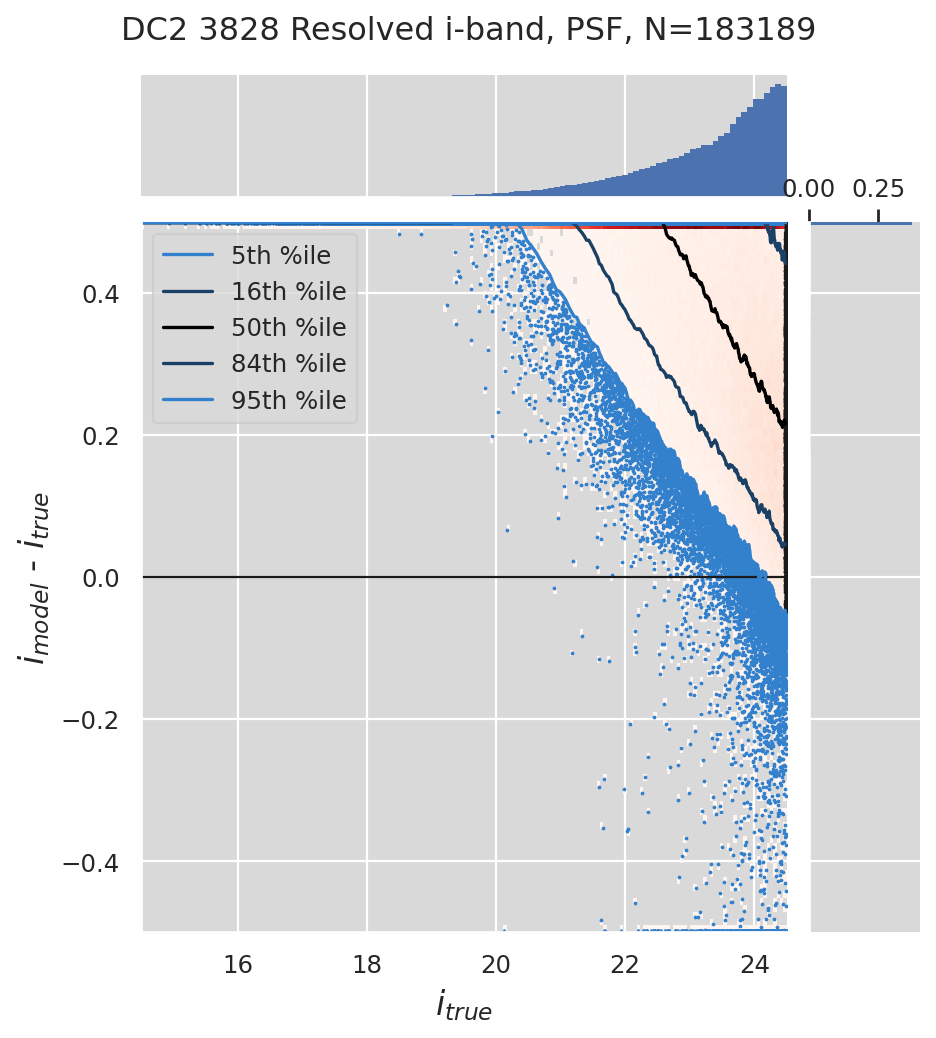

DC2 3828 Resolved z-band, PSF, N=224421


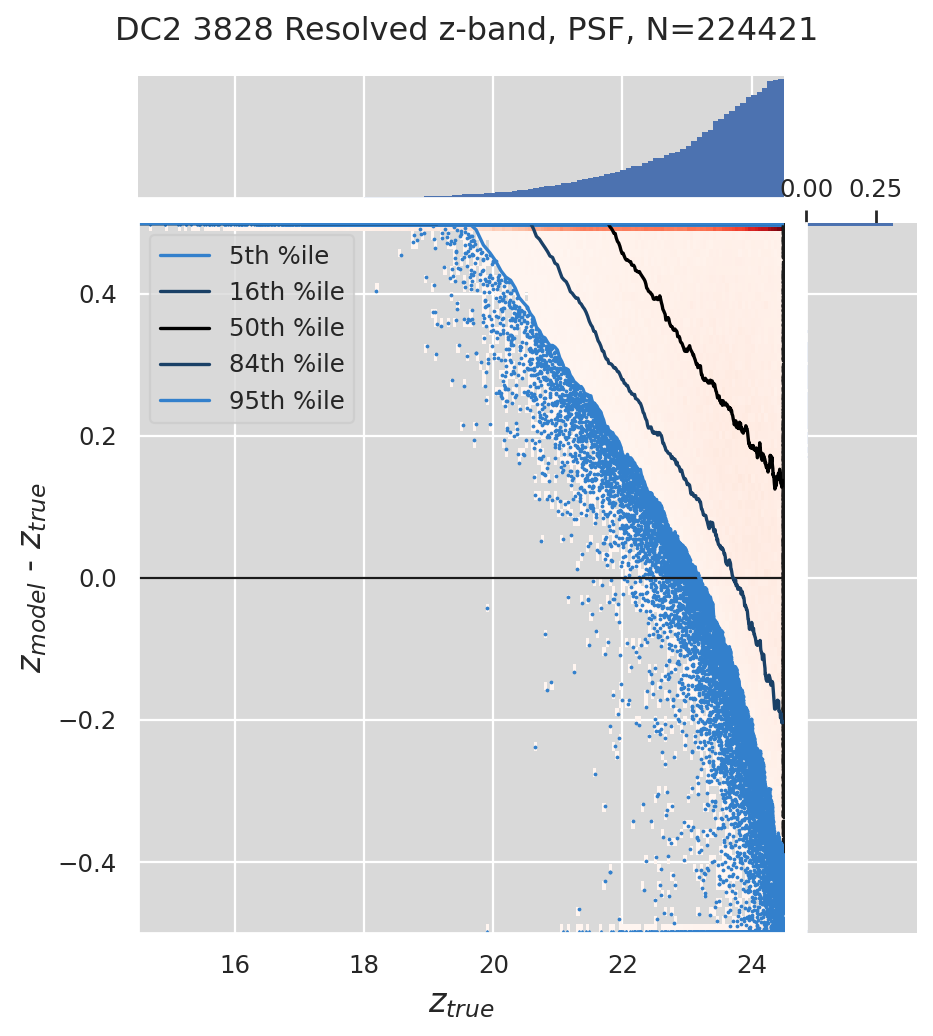

DC2 3828 Resolved g-r, PSF, N=129718


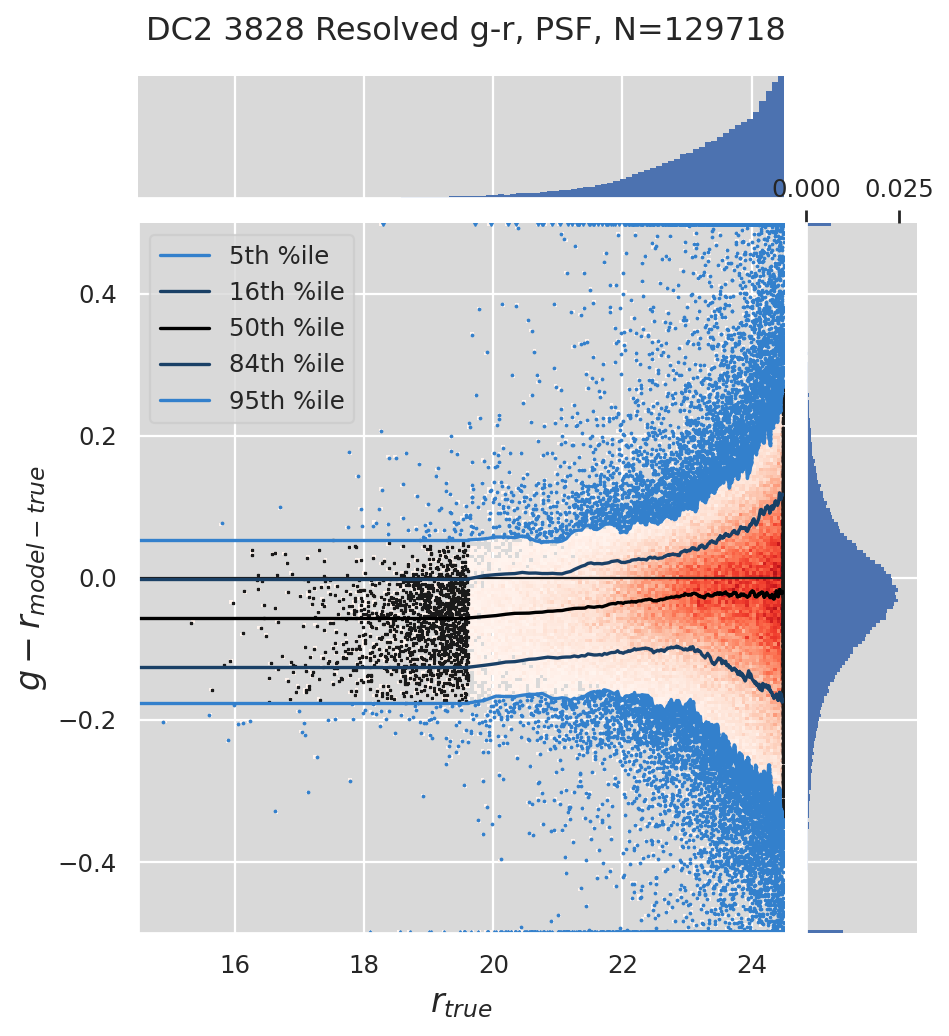

DC2 3828 Resolved r-i, PSF, N=129764


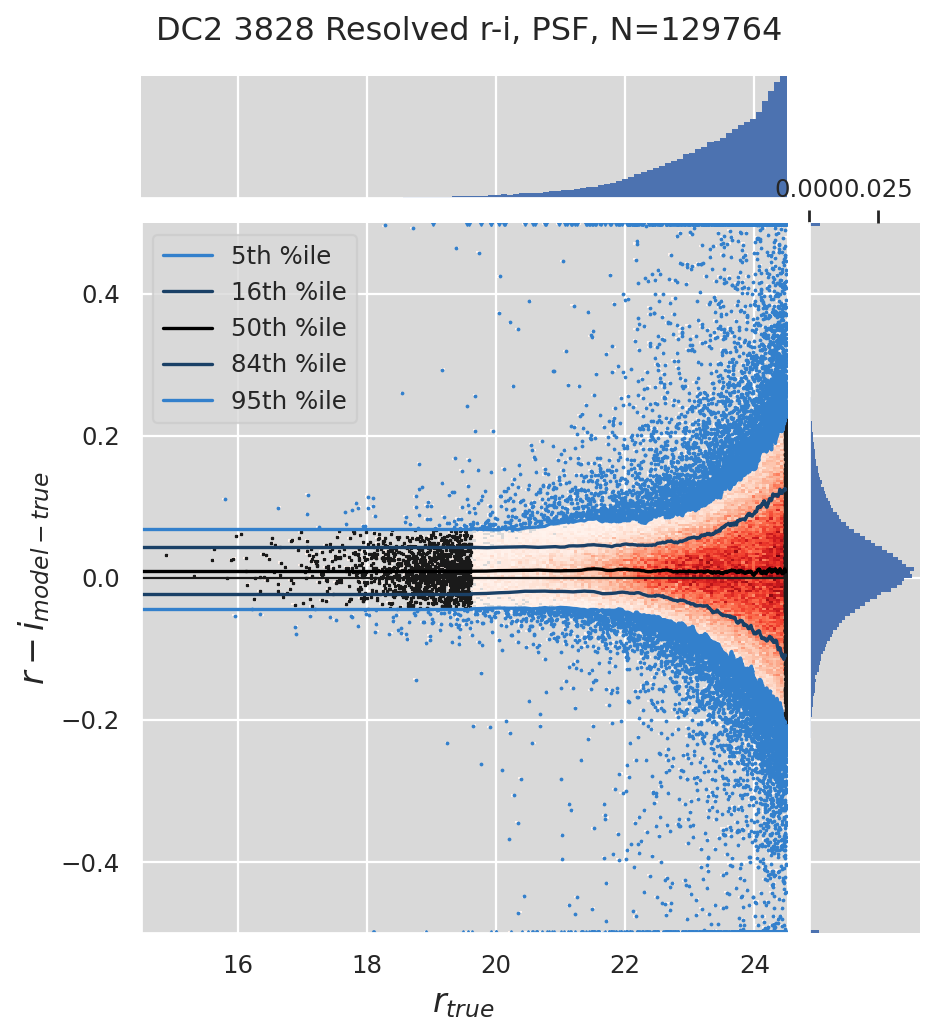

DC2 3828 Resolved i-z, PSF, N=129486


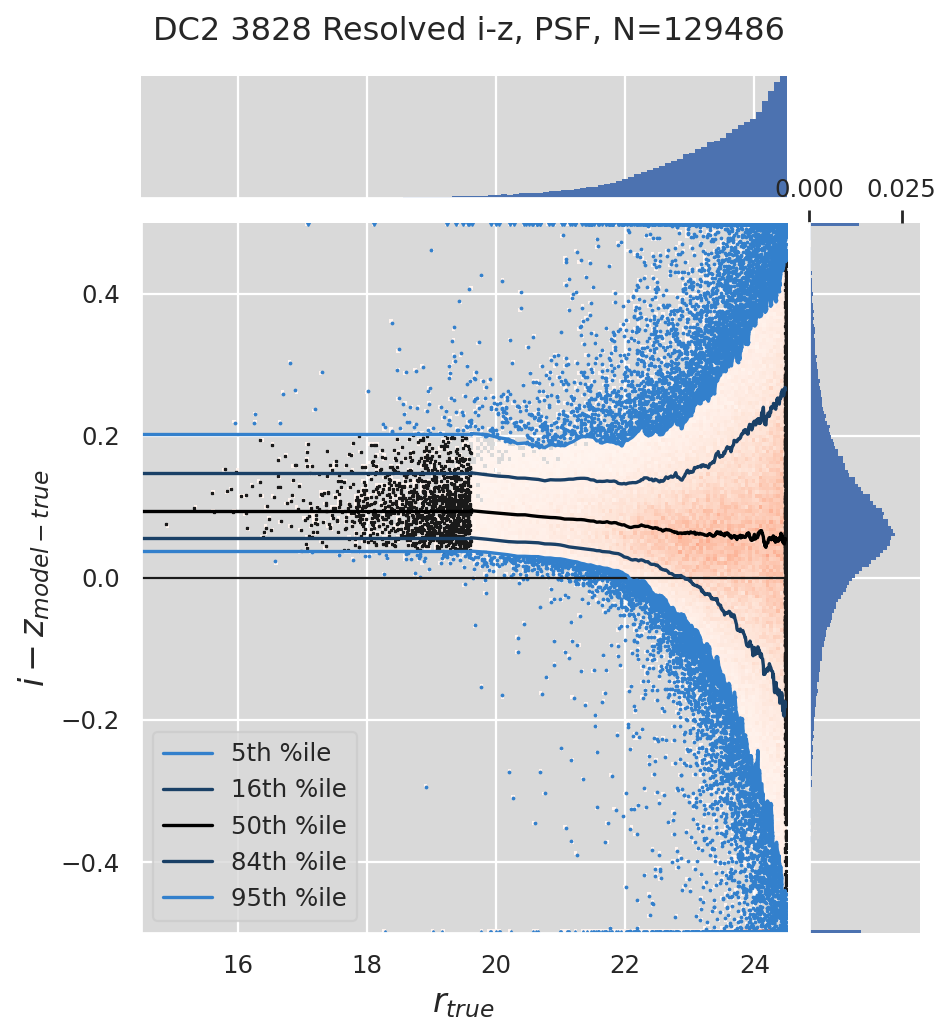

DC2 3828 Resolved g-band, Stack CModel, N=84590


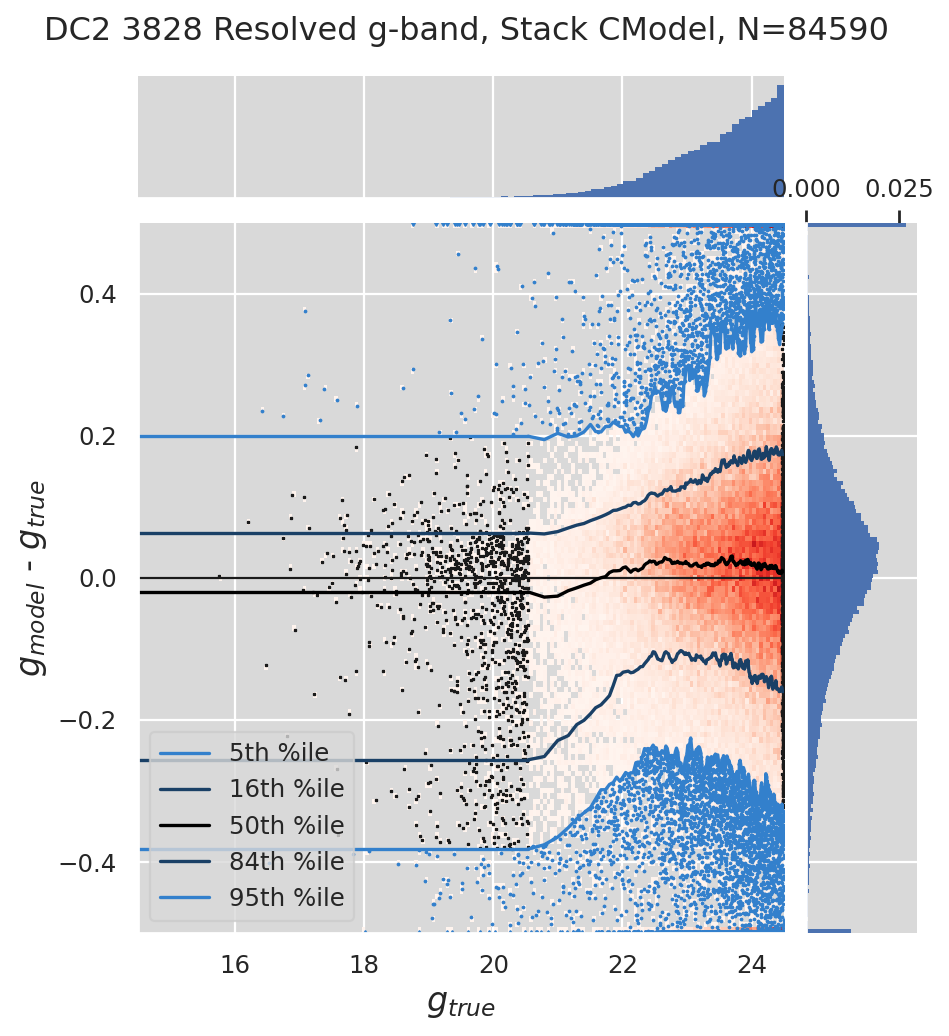

DC2 3828 Resolved r-band, Stack CModel, N=129457


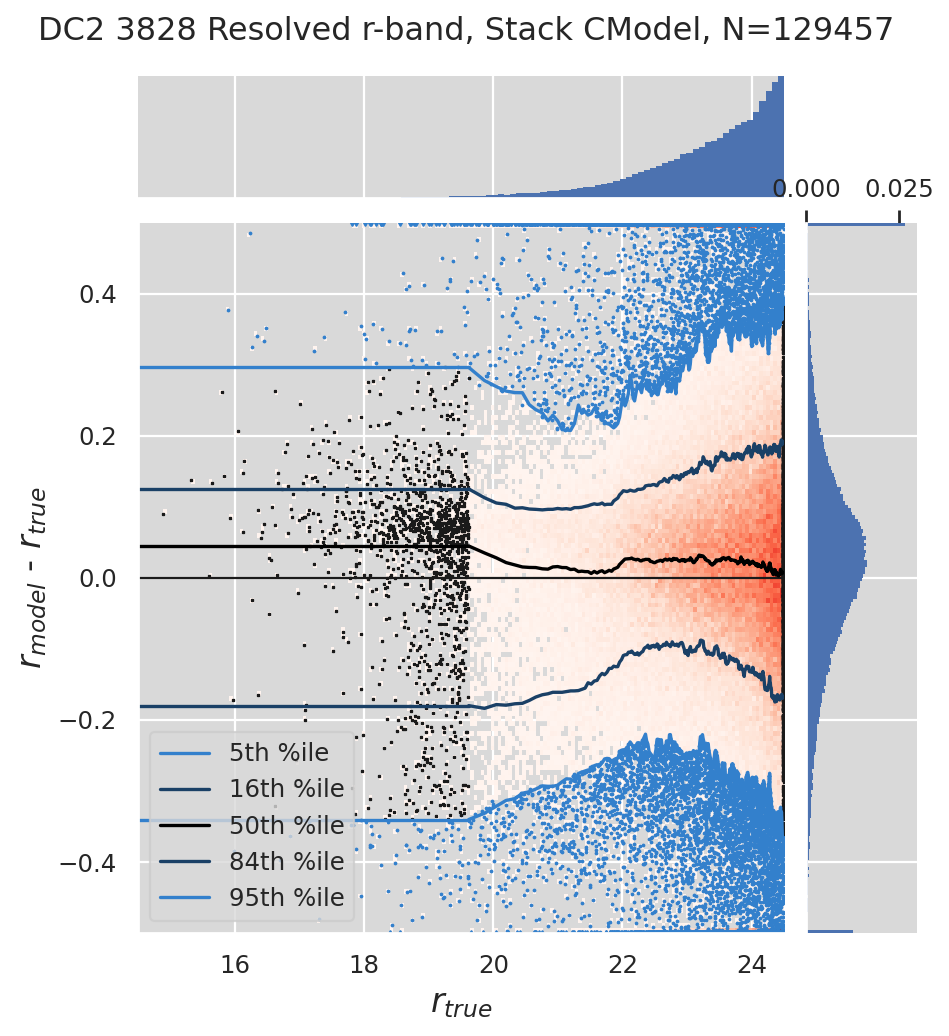

DC2 3828 Resolved i-band, Stack CModel, N=182781


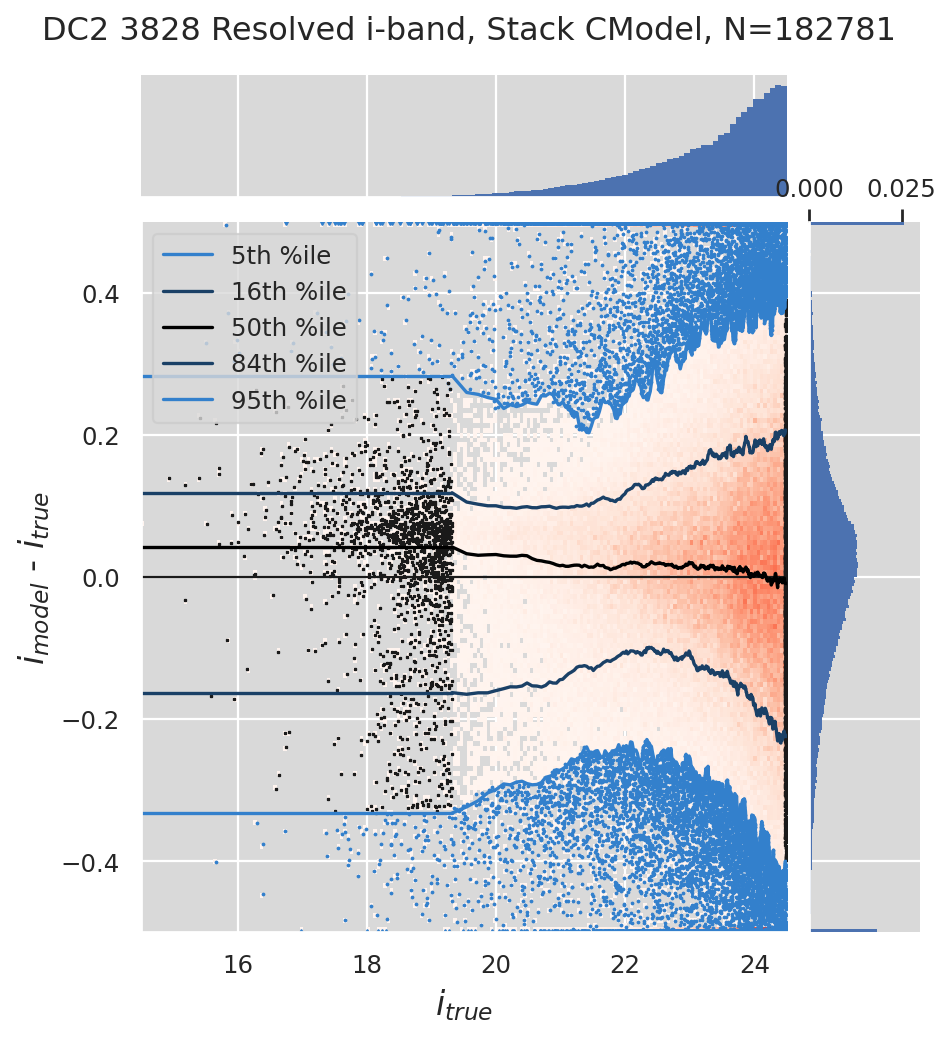

DC2 3828 Resolved z-band, Stack CModel, N=223541


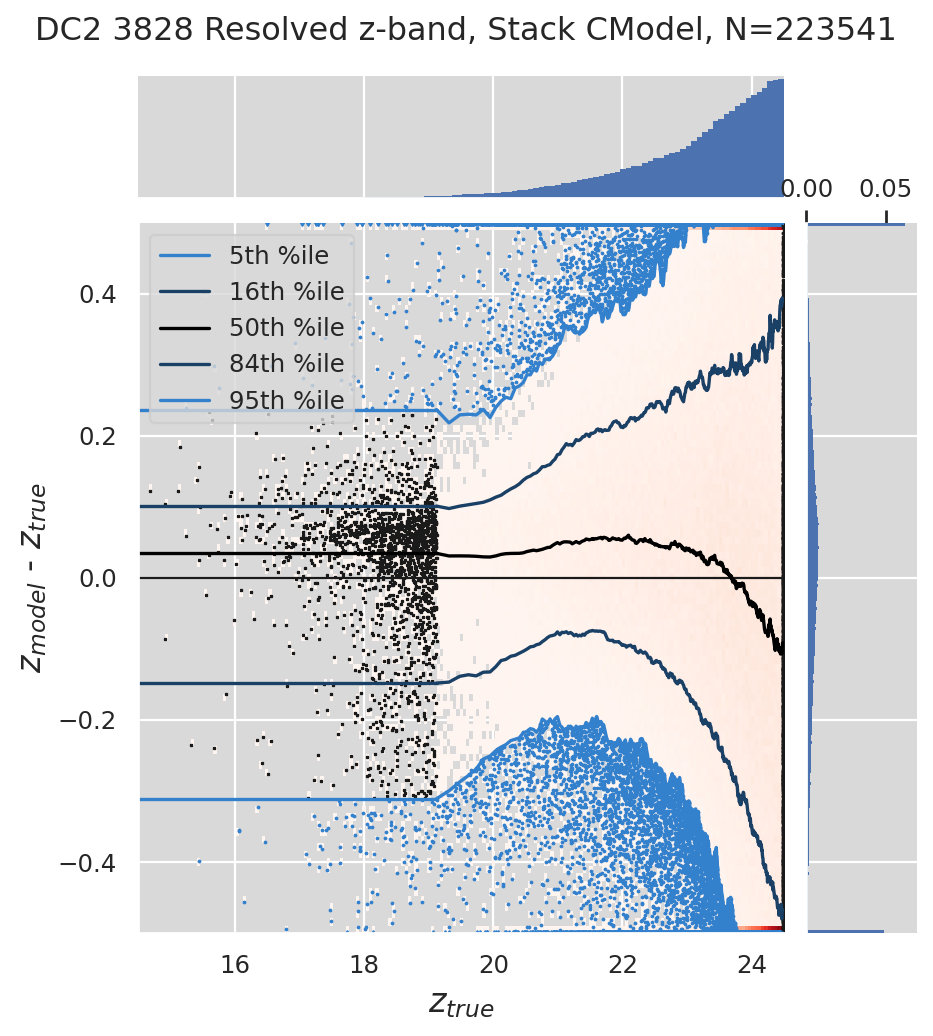

DC2 3828 Resolved g-r, Stack CModel, N=129084


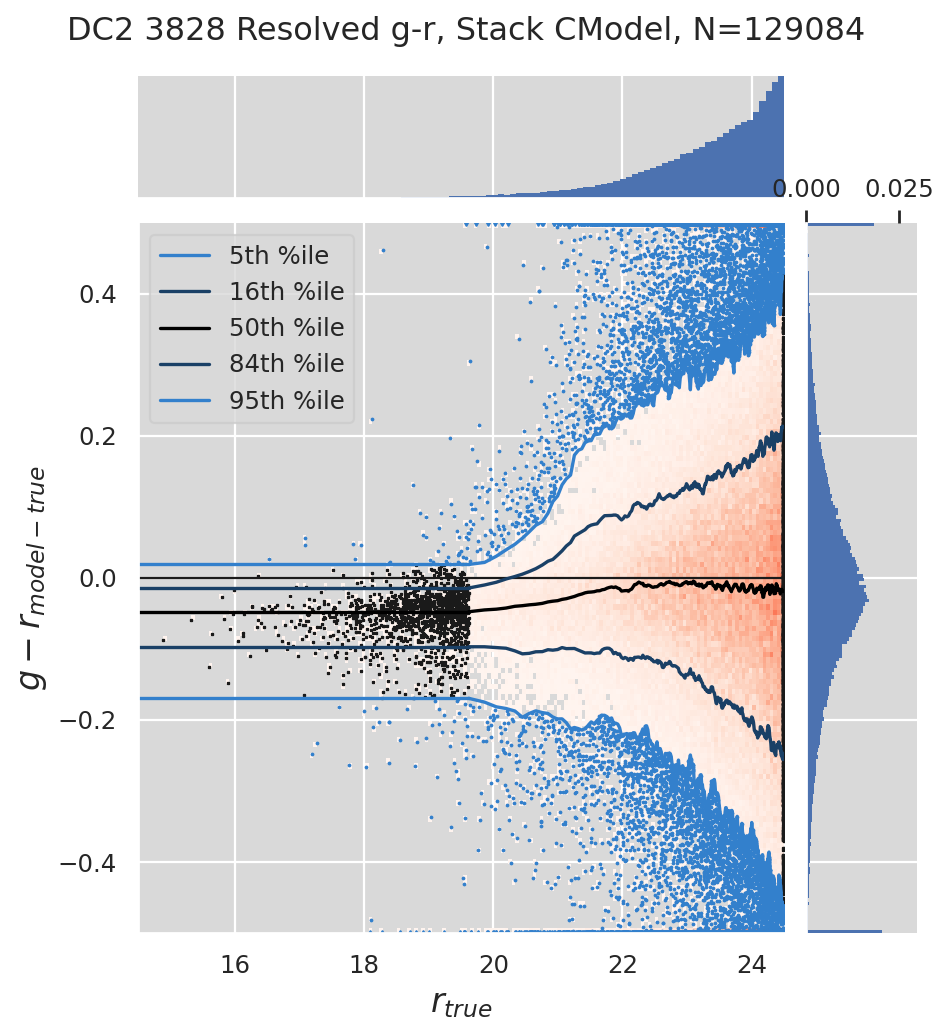

DC2 3828 Resolved r-i, Stack CModel, N=129262


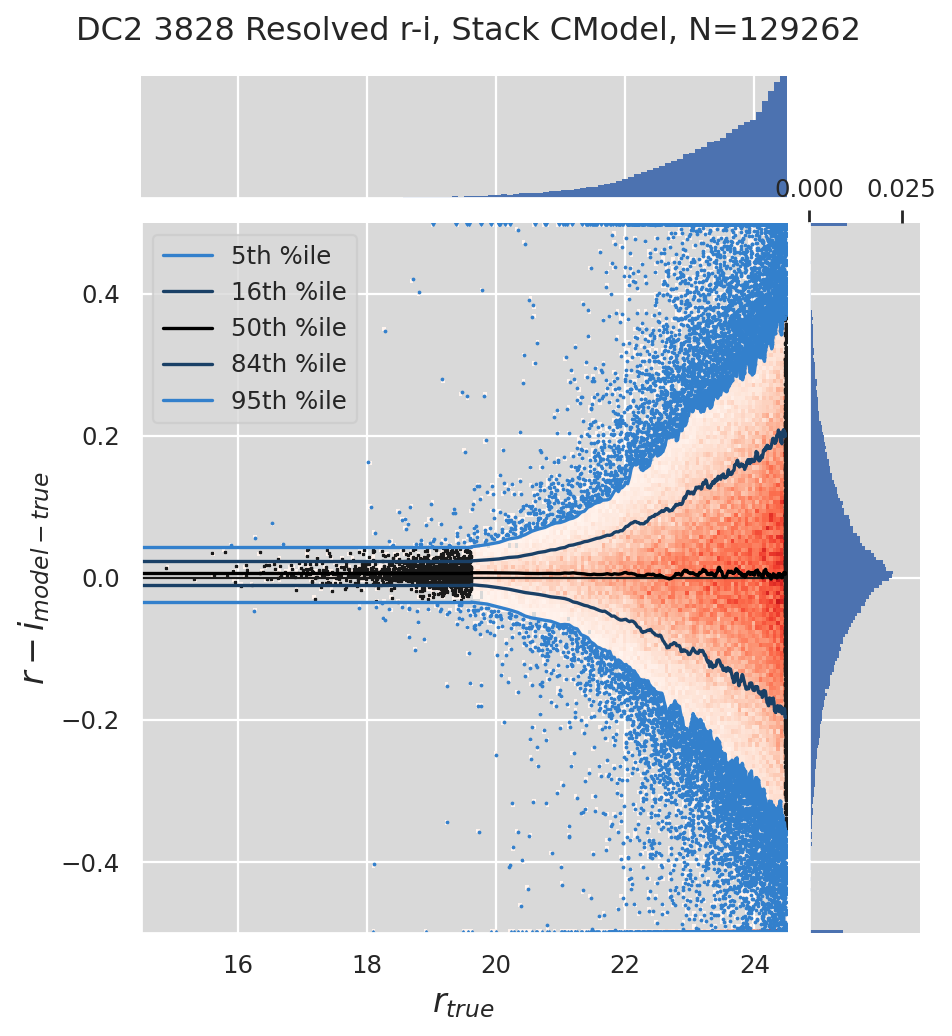

DC2 3828 Resolved i-z, Stack CModel, N=128800


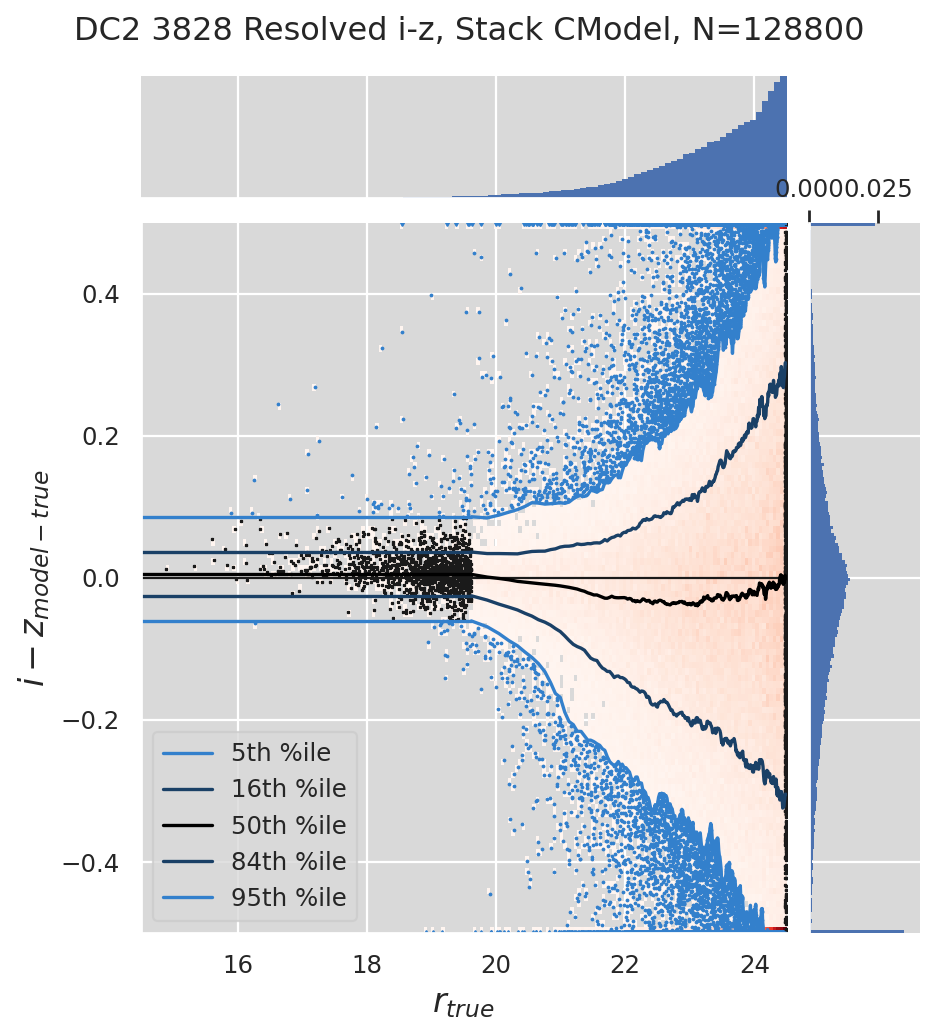

DC2 3828 Resolved g-band, Forced CModel, N=84697


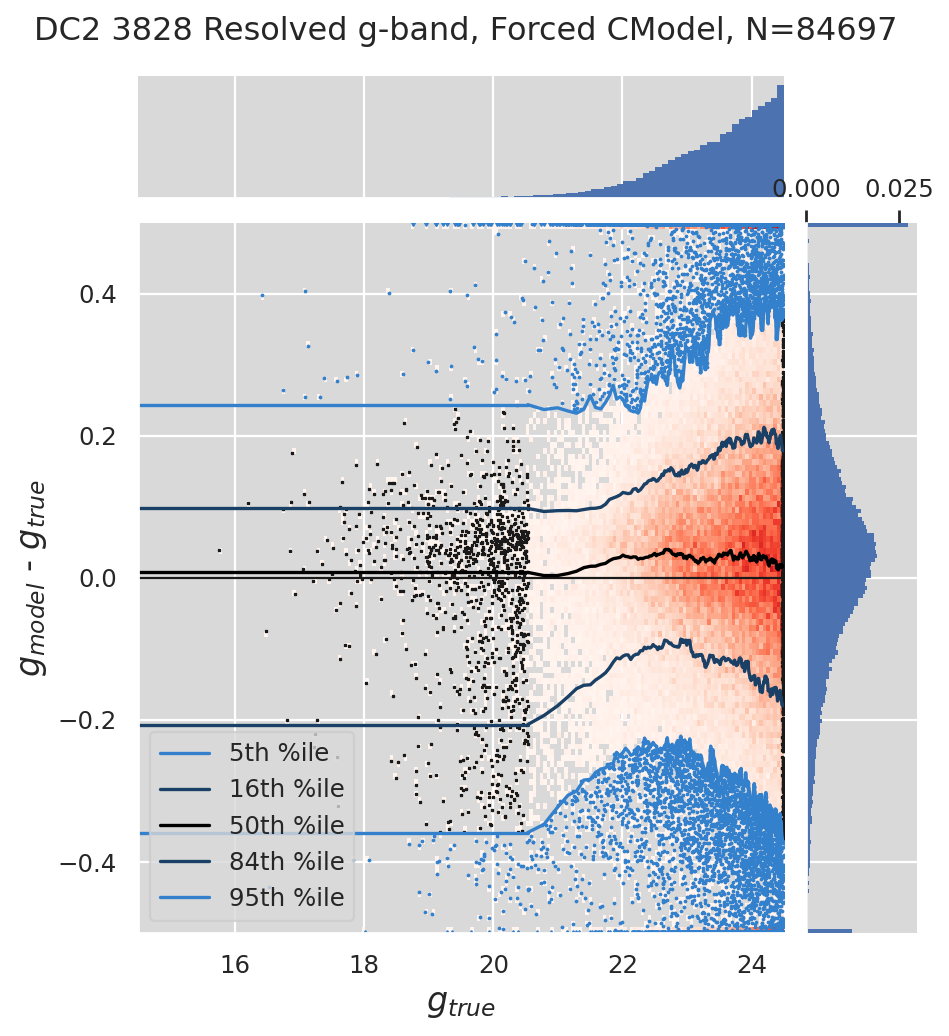

DC2 3828 Resolved r-band, Forced CModel, N=129614


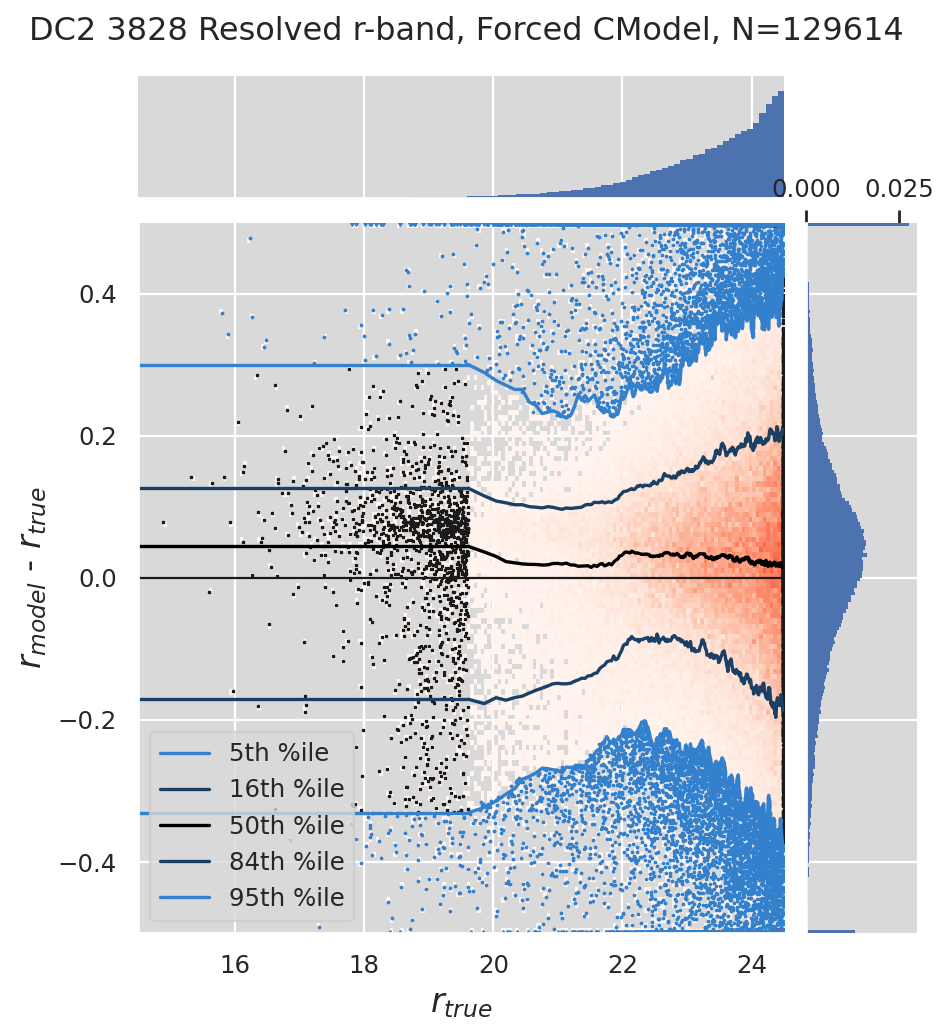

DC2 3828 Resolved i-band, Forced CModel, N=182989


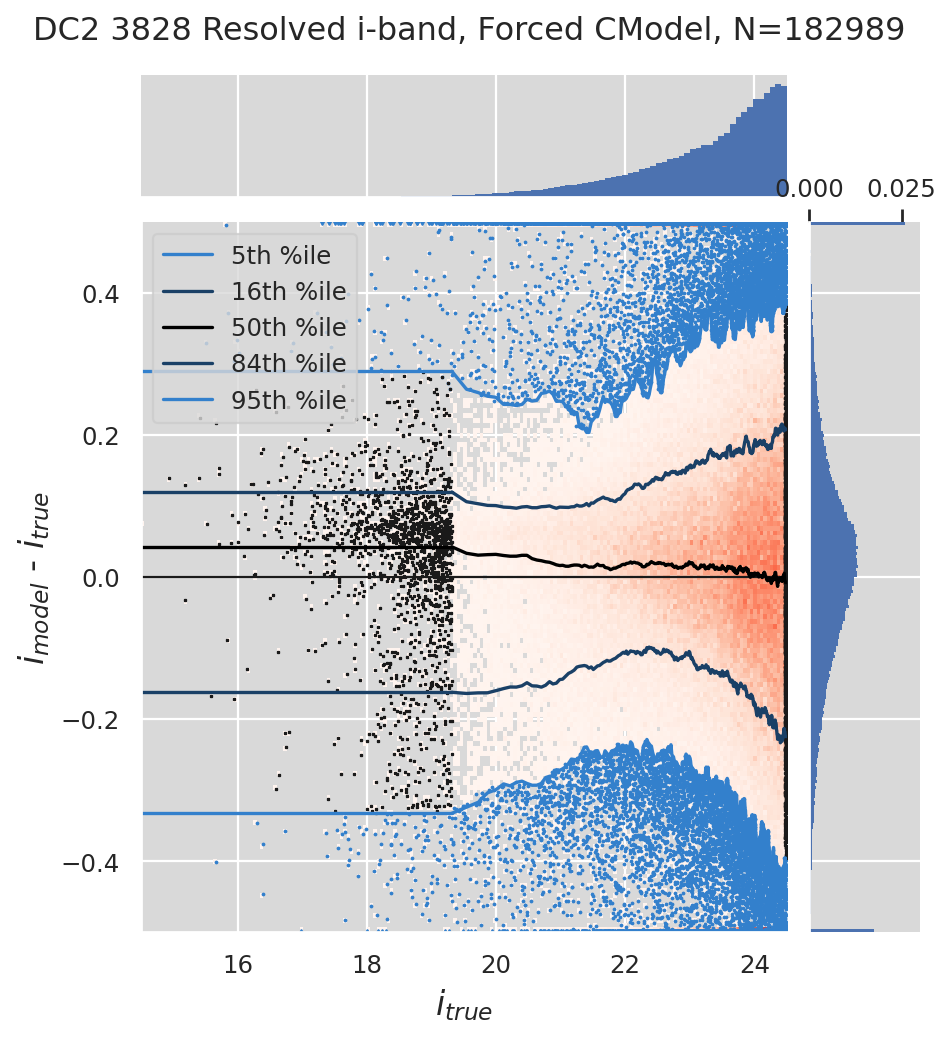

DC2 3828 Resolved z-band, Forced CModel, N=223758


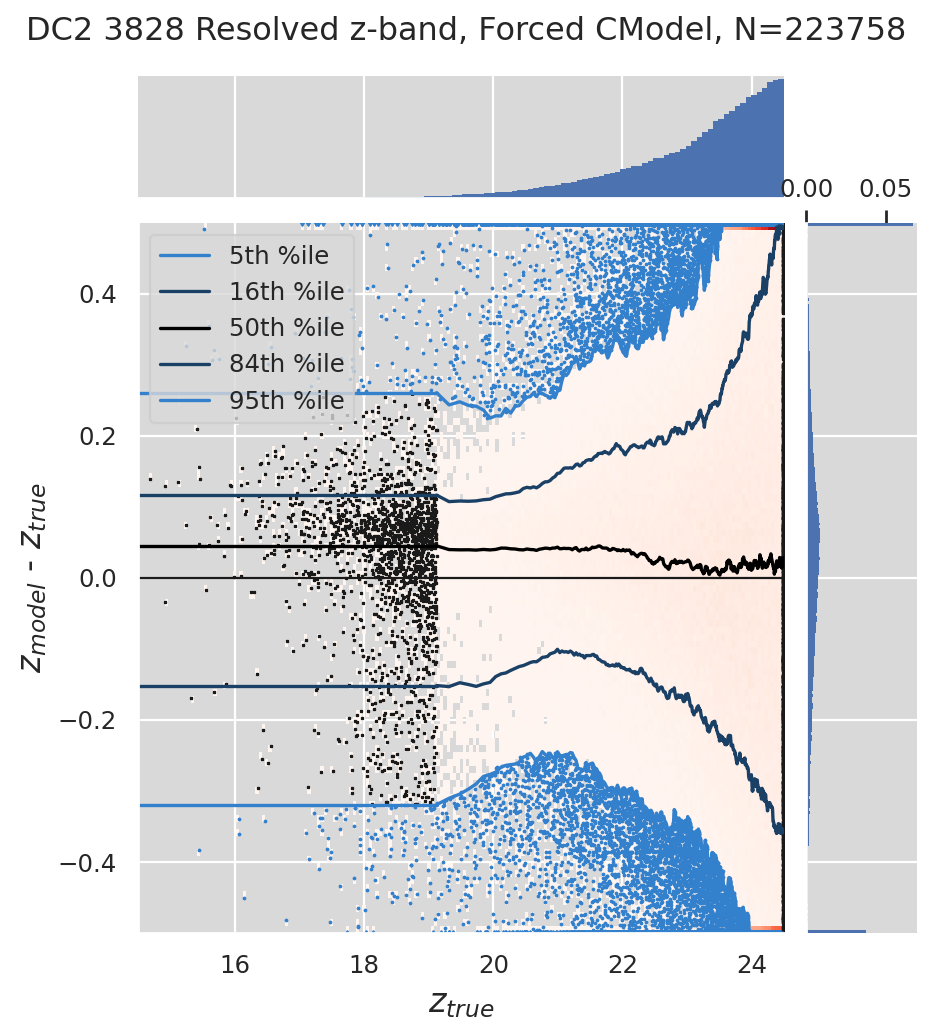

/home/dtaranu/src/mine/modelling_research/plot_matches.py:436: RuntimeWarning: invalid value encountered in subtract
  y = mags_diff[b1][multi][good_band] - mags_diff[b2][multi][good_band]


DC2 3828 Resolved g-r, Forced CModel, N=129333


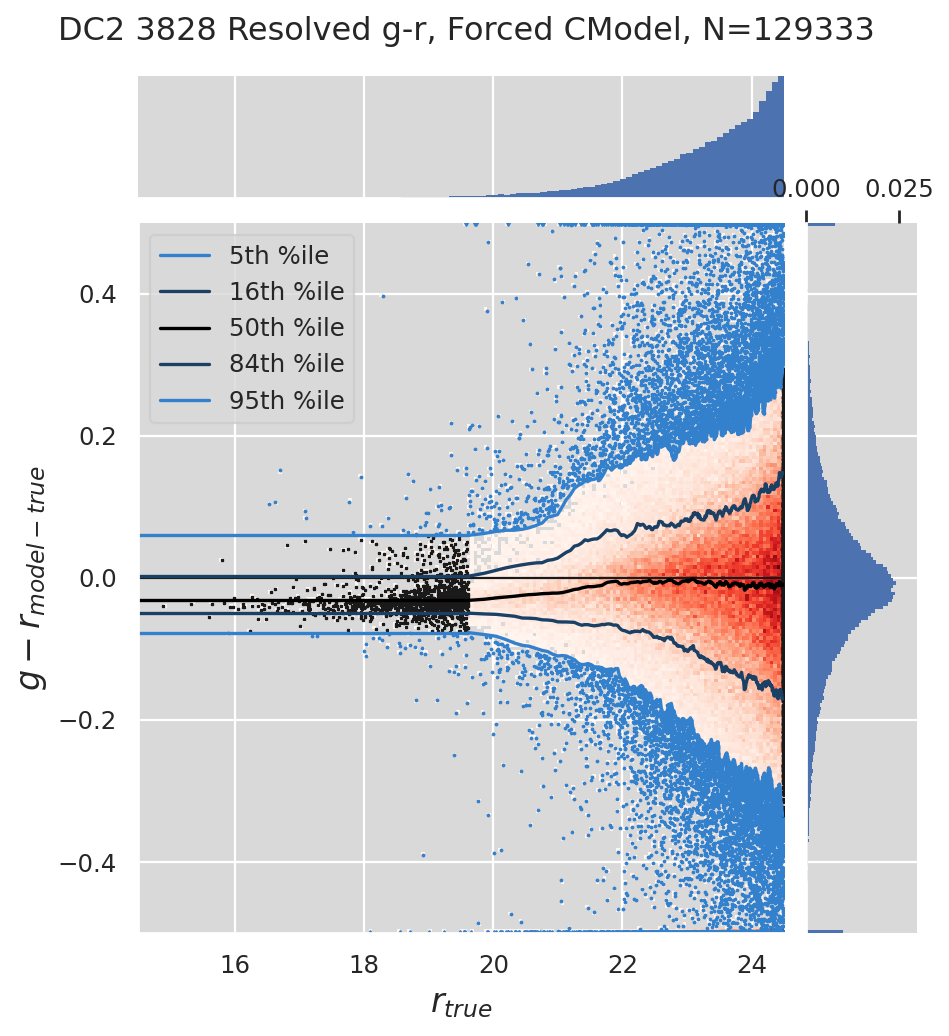

/home/dtaranu/src/mine/modelling_research/plot_matches.py:436: RuntimeWarning: invalid value encountered in subtract
  y = mags_diff[b1][multi][good_band] - mags_diff[b2][multi][good_band]


DC2 3828 Resolved r-i, Forced CModel, N=129485


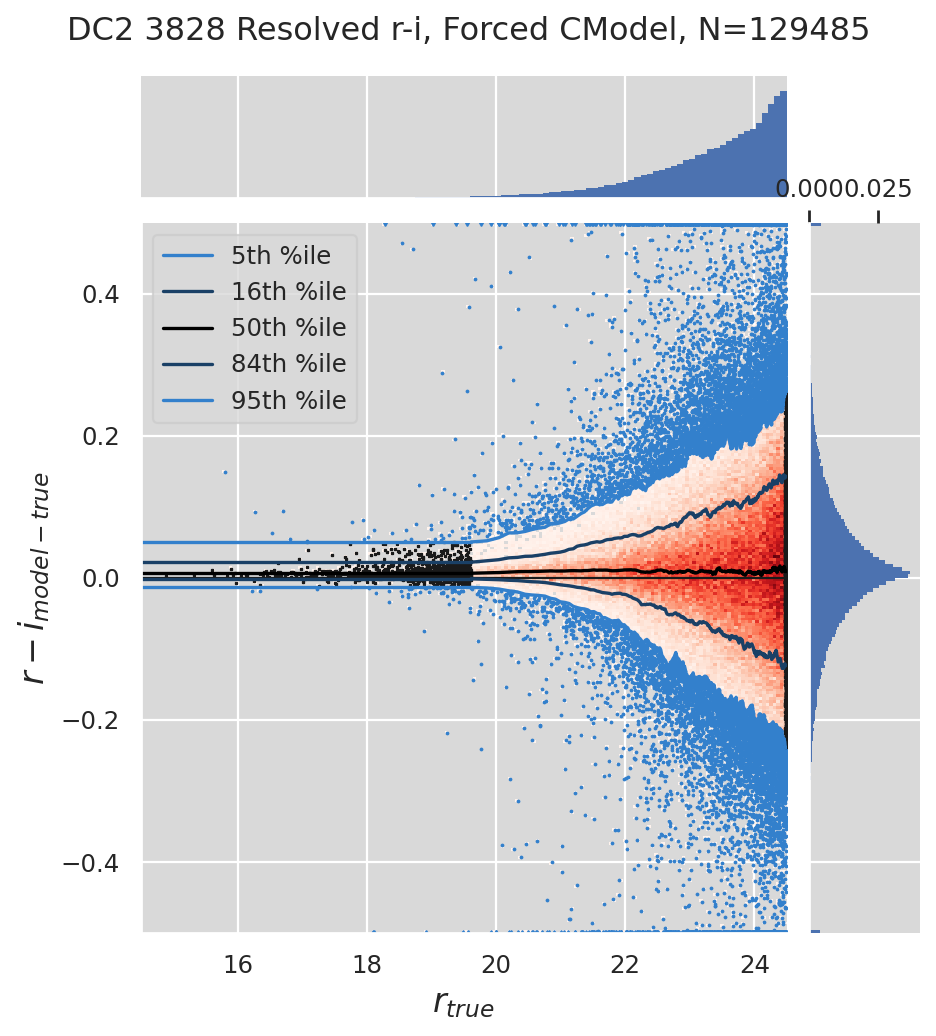

/home/dtaranu/src/mine/modelling_research/plot_matches.py:436: RuntimeWarning: invalid value encountered in subtract
  y = mags_diff[b1][multi][good_band] - mags_diff[b2][multi][good_band]


DC2 3828 Resolved i-z, Forced CModel, N=129074


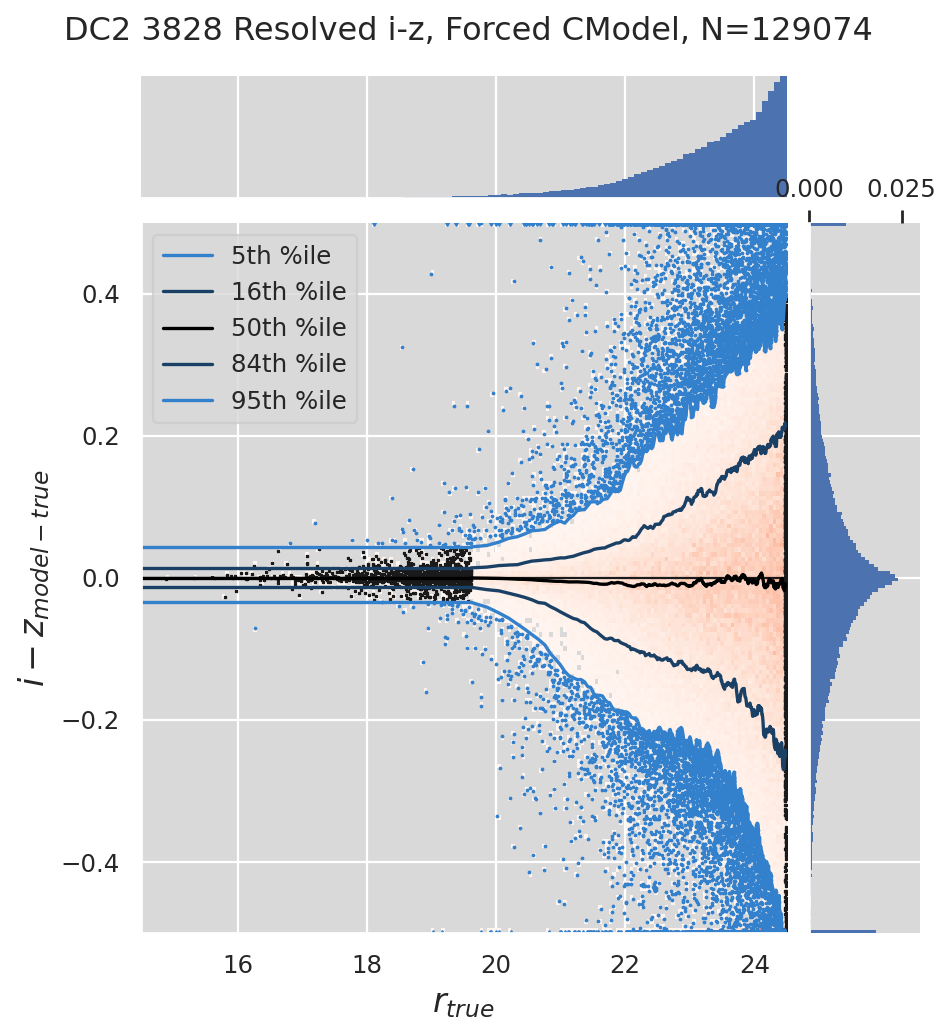

{}

In [8]:
# Galaxies
args['densityplot'] = sns.histplot
plot_matches(
    cats, True, models, filters_single, band_ref=band_ref, band_multi=band_multi,
    band_ref_multi=band_ref, mag_max=24.5, match_dist_asec=0.168,
    plot_compure=False, rematch=True, **args_type['resolved'], **args
)

## Point source fluxes and colours

There's not much to say here, other than that the stars look basically fine up to the saturation limit of ~16 and the choice of PSF/source model and single- vs multi-band fitting makes little difference. Someone more versed in stellar photometry might have more to say about the small biases in the medians, outliers, etc.

N=0 sky object matches
Rematched 136/10797; 9207 originally and 9207 rematched already matched
N=0sky object matches after rematching
DC2 3828 Unresolved g-band, PSF, N=7365


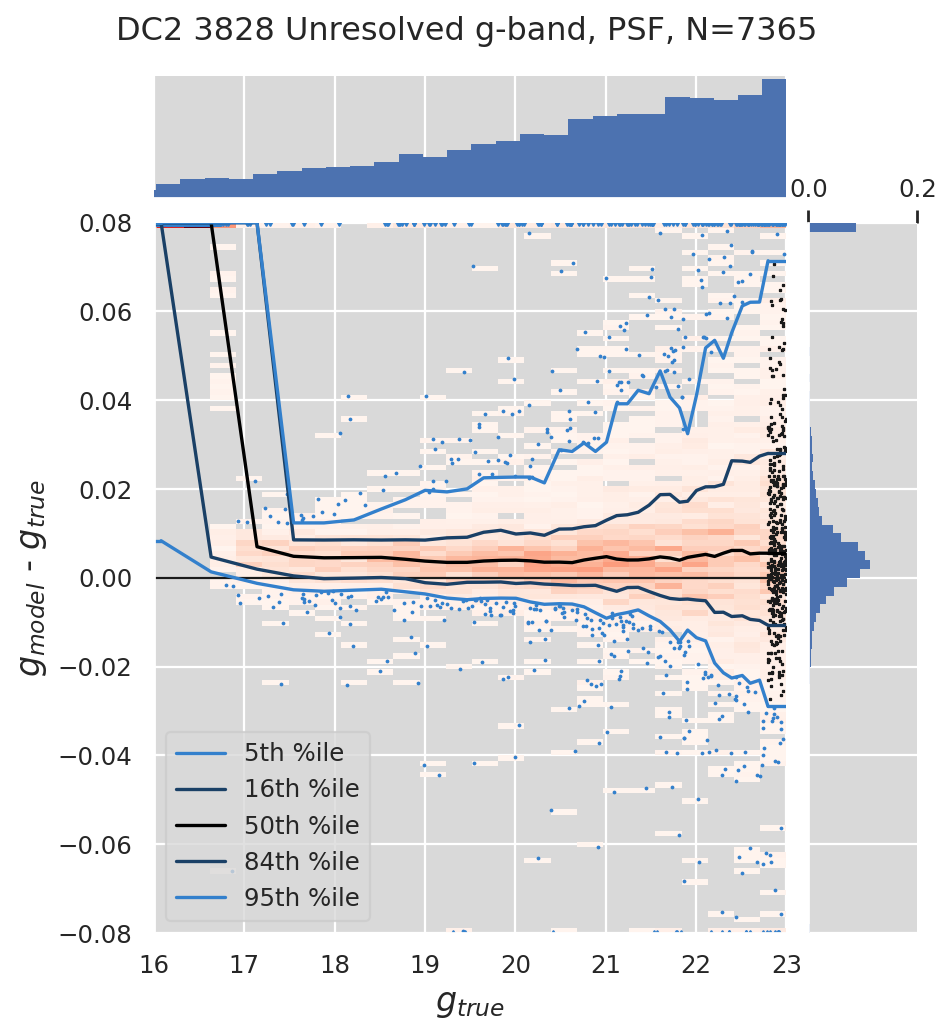

DC2 3828 Unresolved r-band, PSF, N=9337


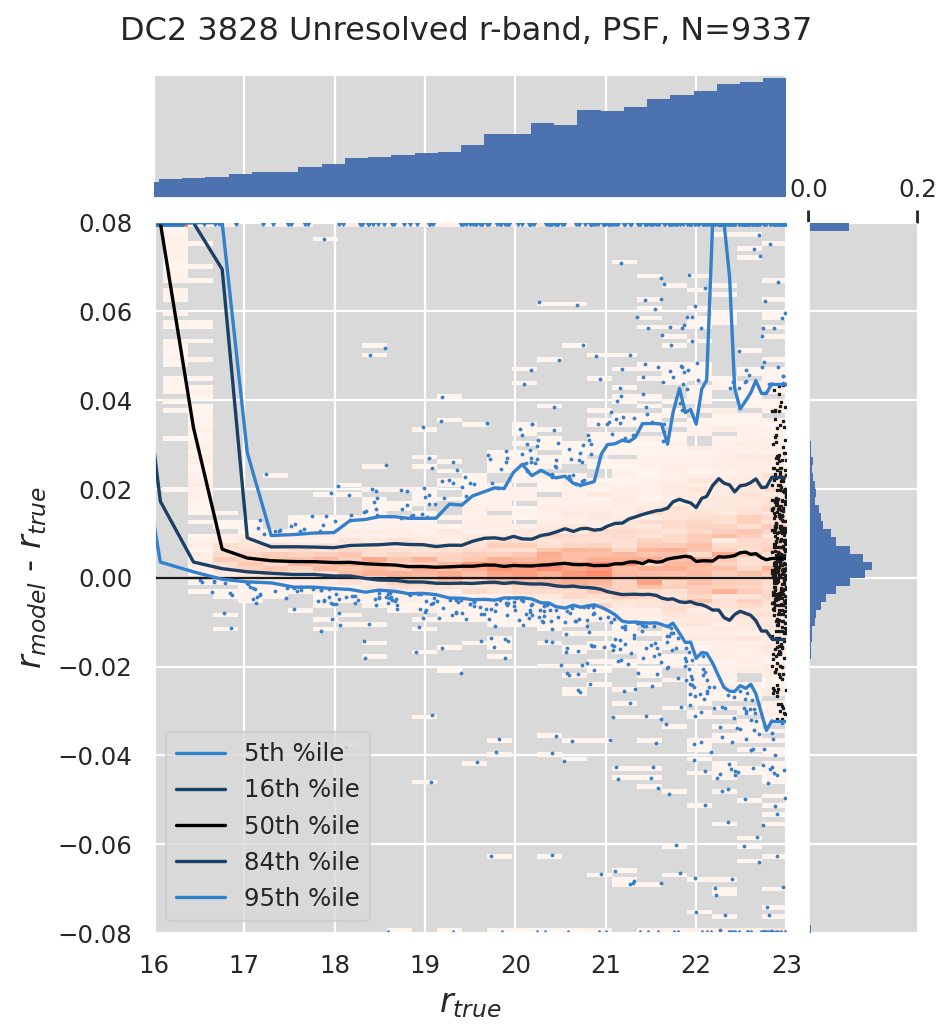

DC2 3828 Unresolved i-band, PSF, N=9336


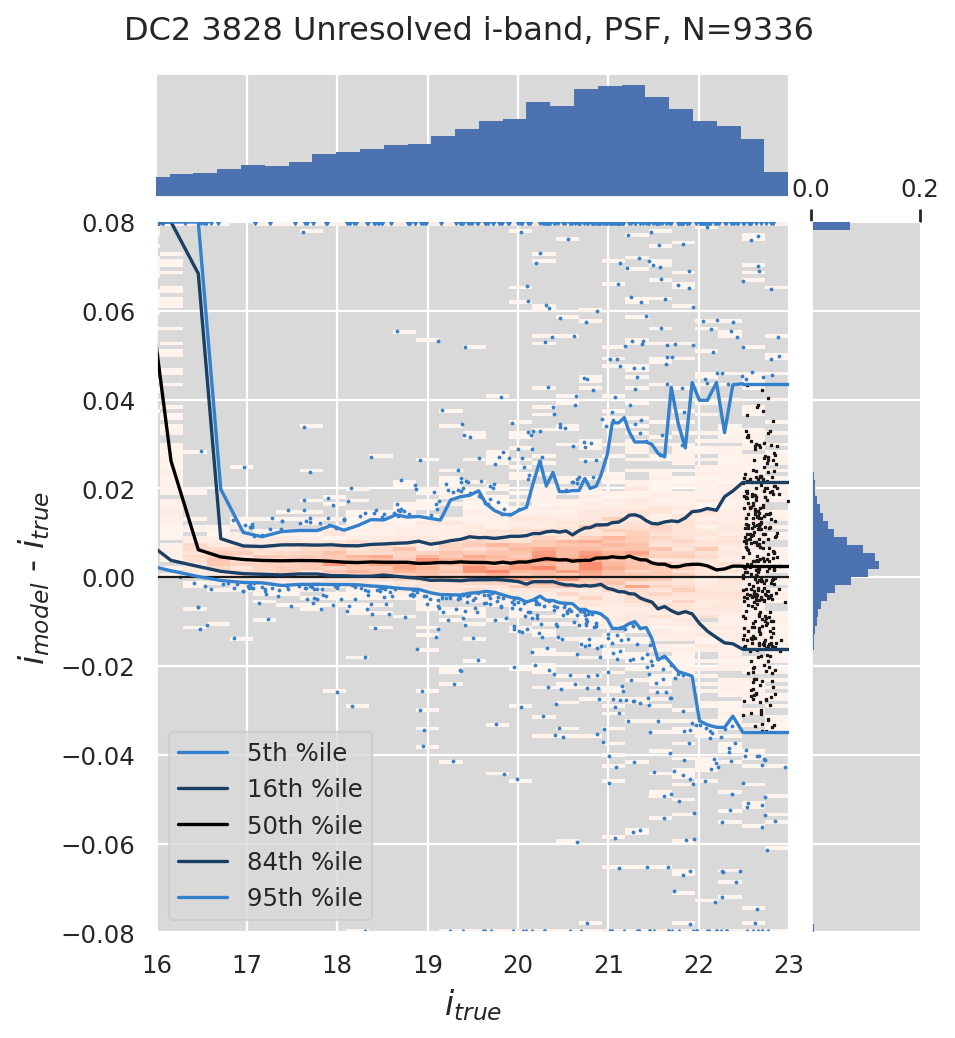

DC2 3828 Unresolved z-band, PSF, N=9331


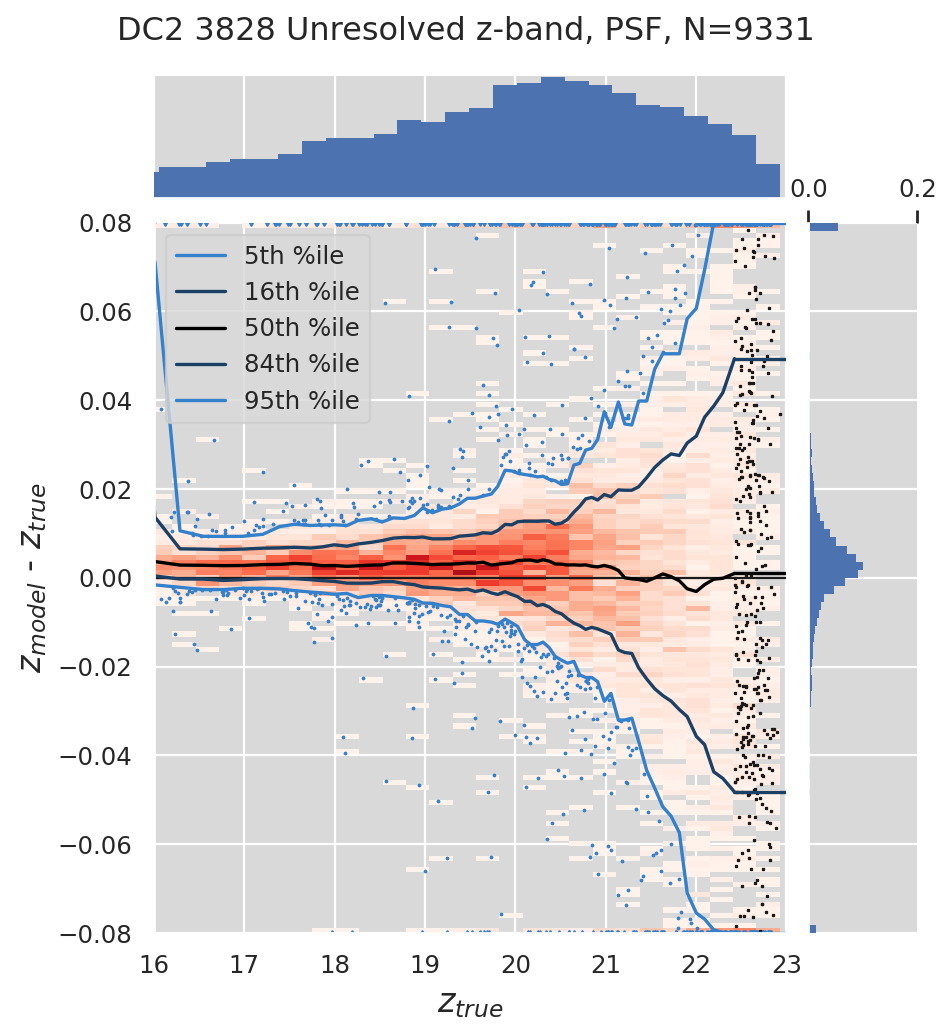

DC2 3828 Unresolved g-r, PSF, N=9334


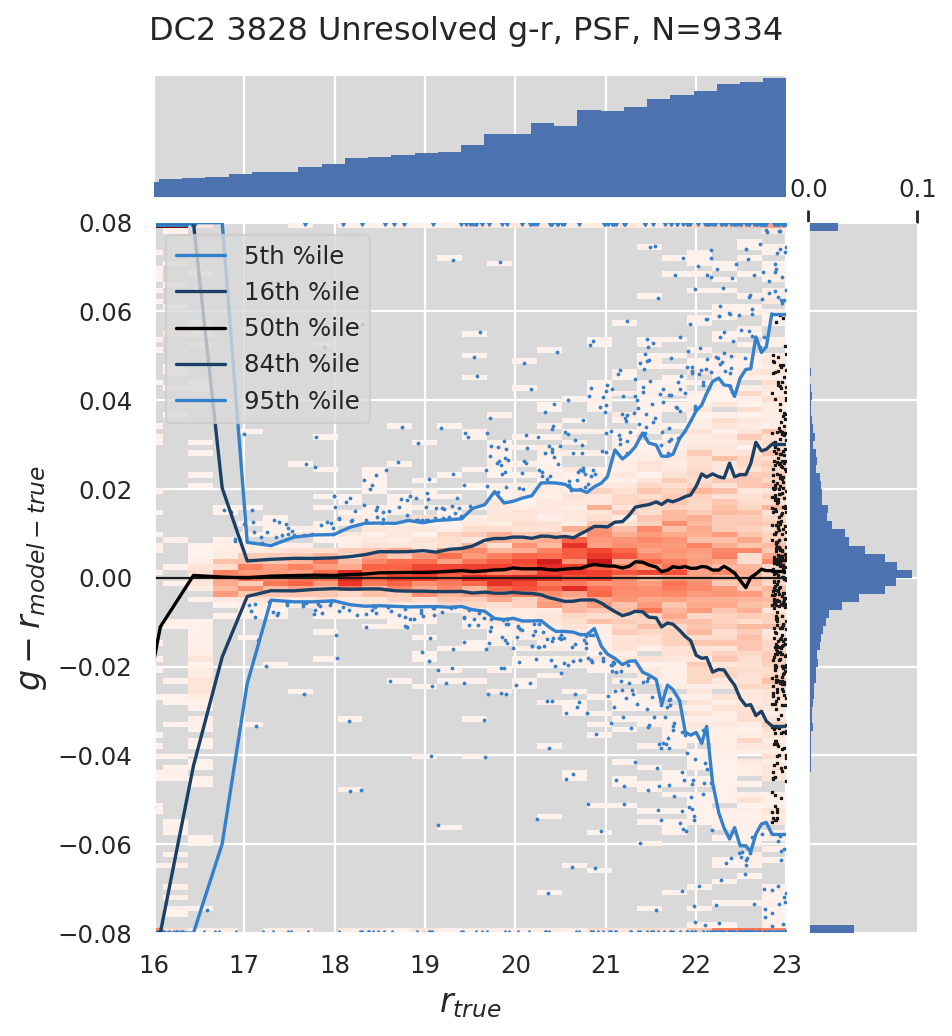

DC2 3828 Unresolved r-i, PSF, N=9332


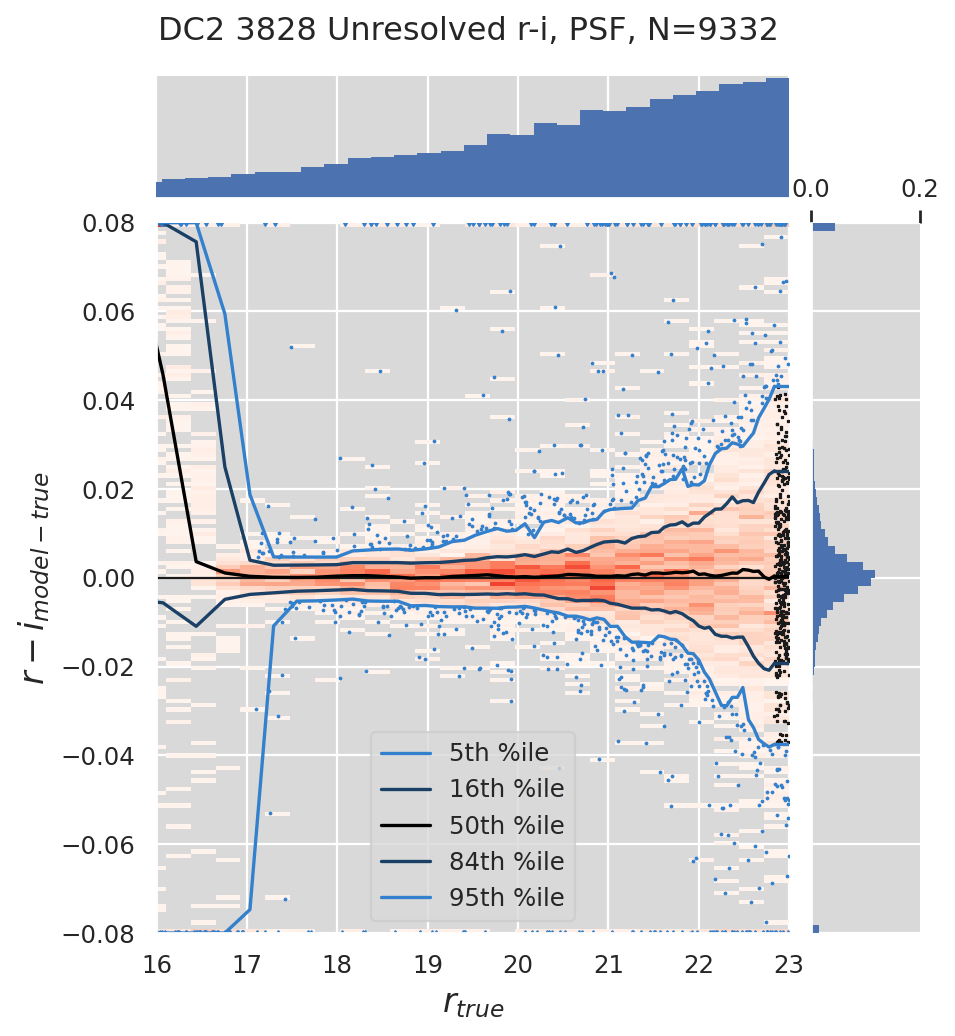

DC2 3828 Unresolved i-z, PSF, N=9330


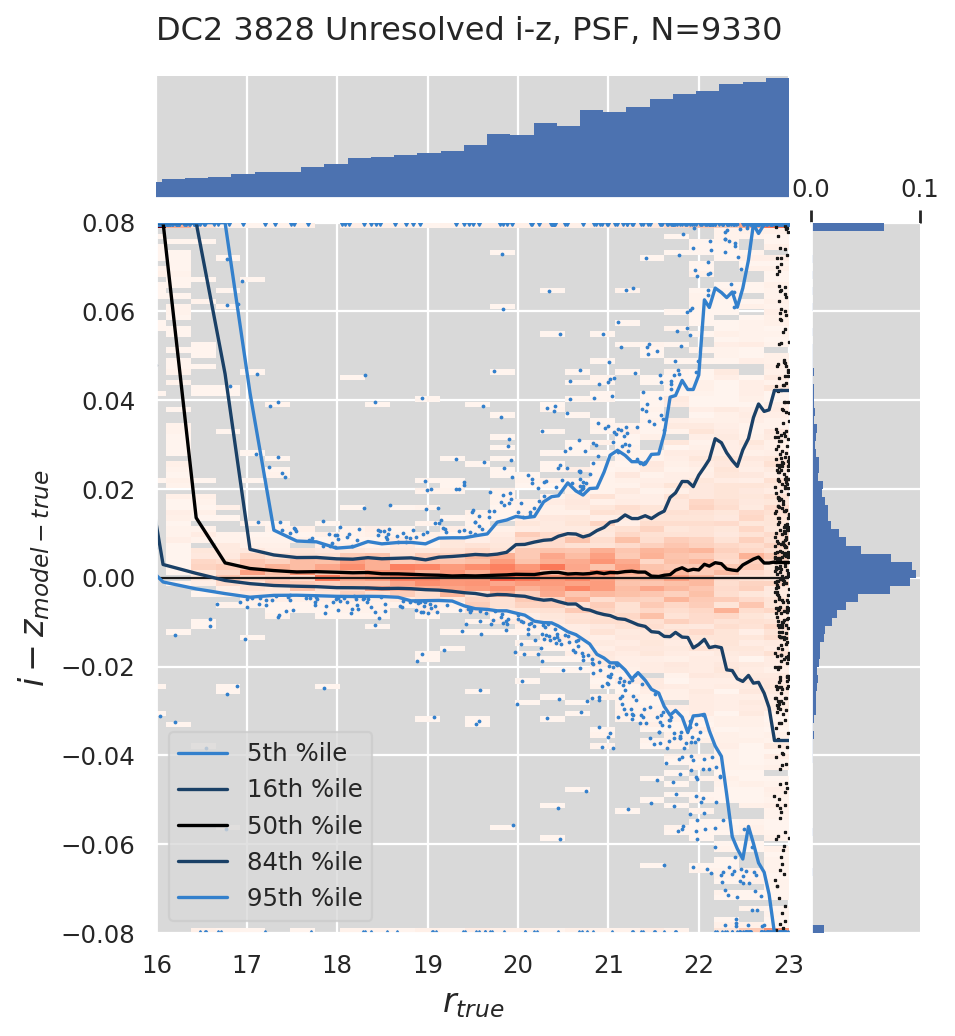

DC2 3828 Unresolved g-band, Stack CModel, N=6862


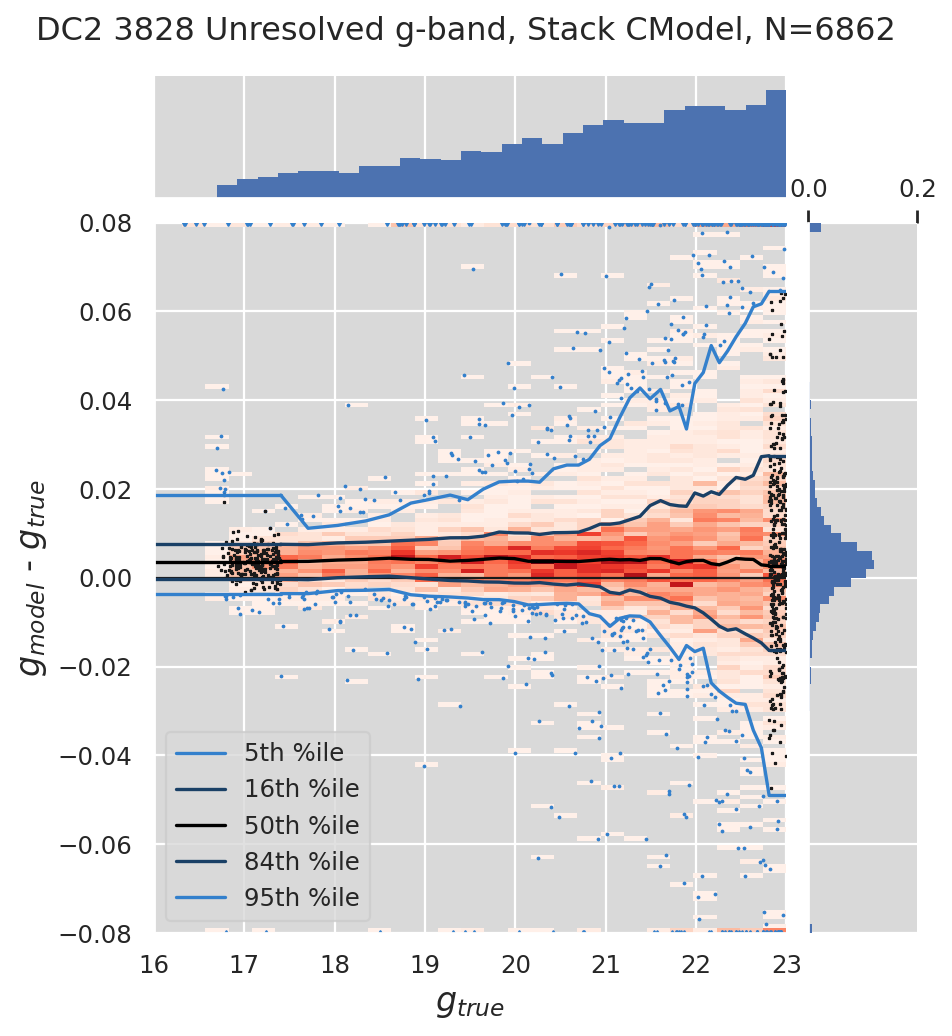

DC2 3828 Unresolved r-band, Stack CModel, N=8757


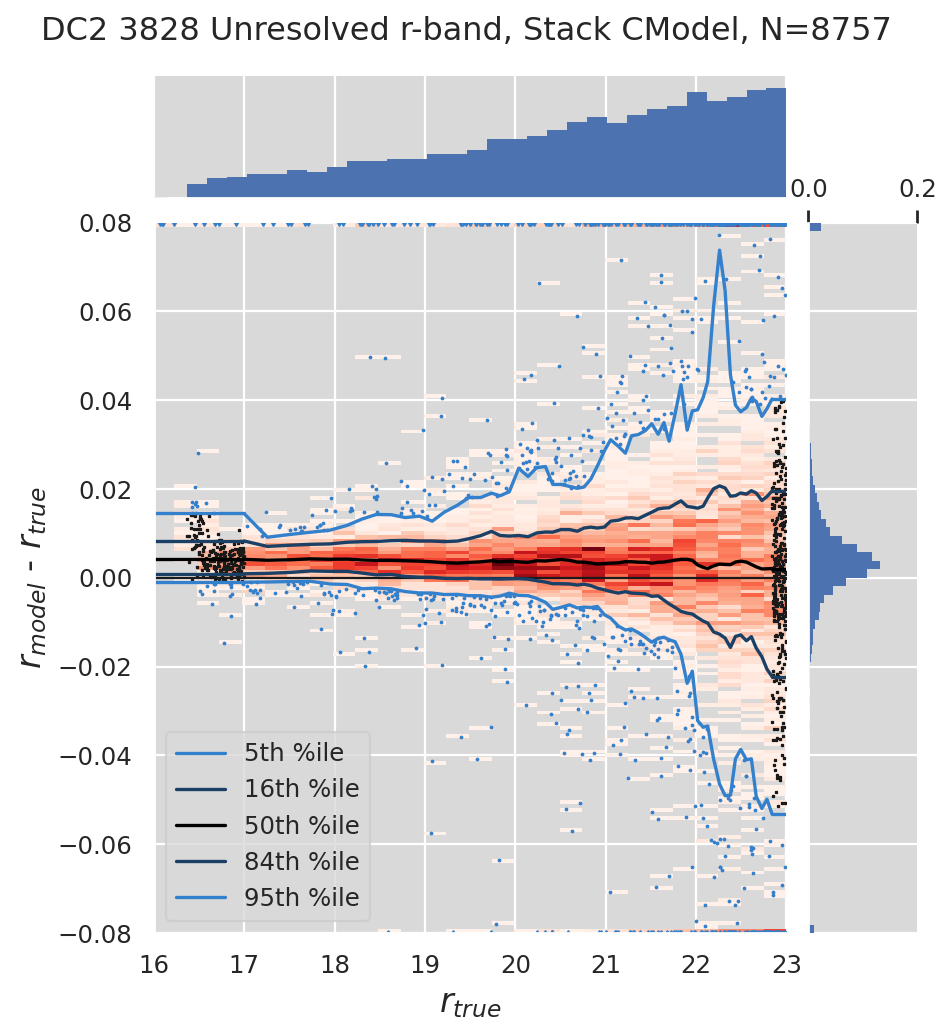

DC2 3828 Unresolved i-band, Stack CModel, N=8772


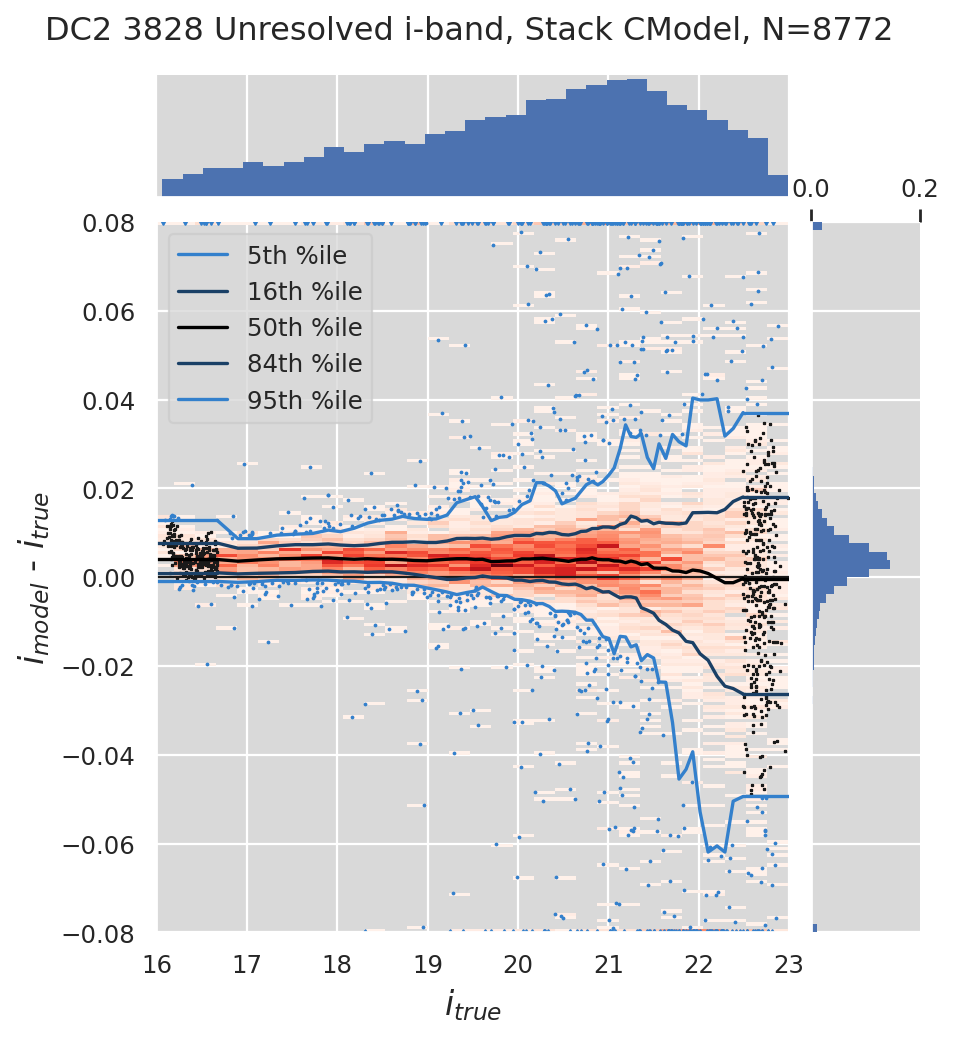

DC2 3828 Unresolved z-band, Stack CModel, N=8948


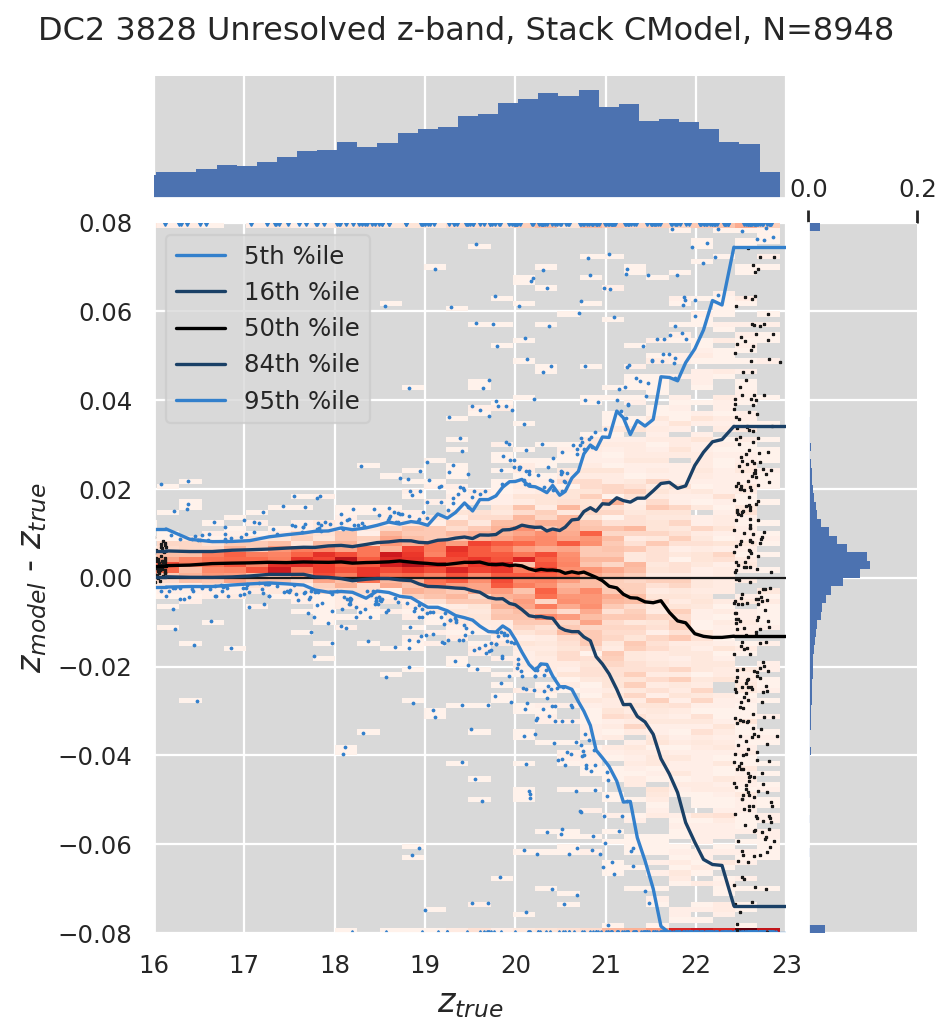

DC2 3828 Unresolved g-r, Stack CModel, N=8728


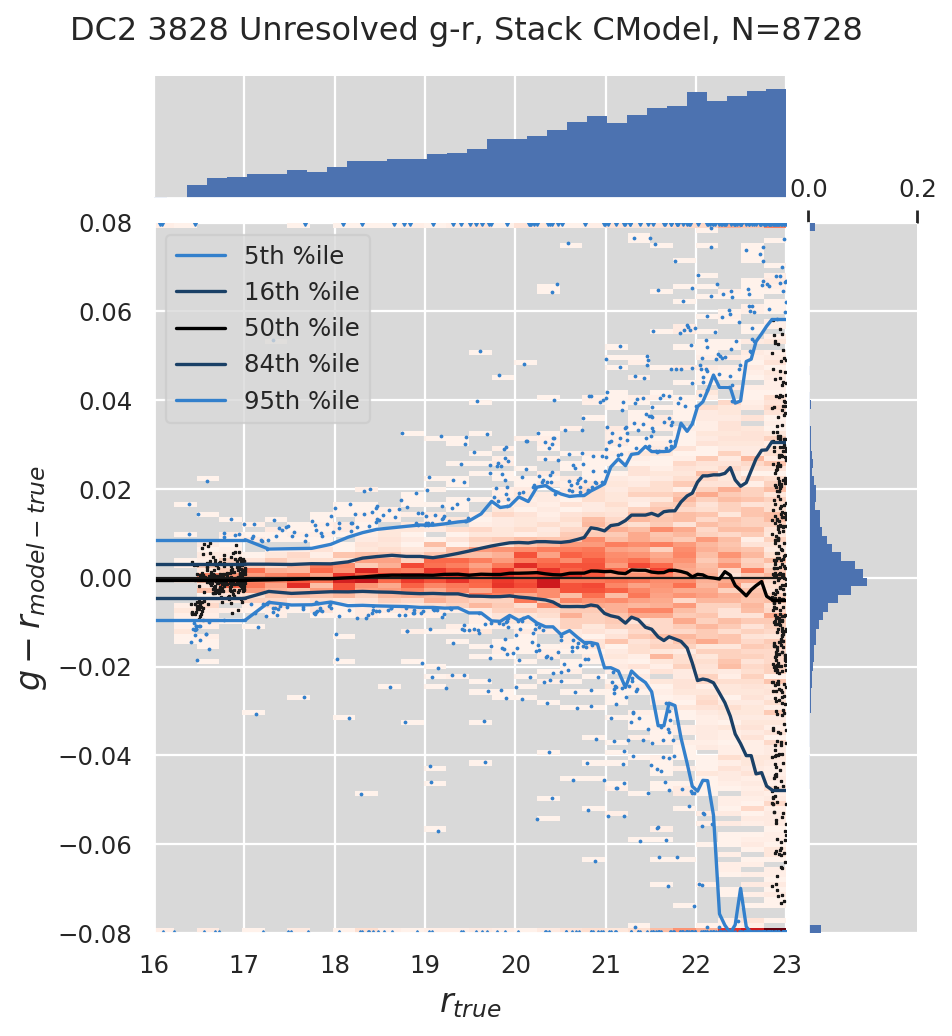

DC2 3828 Unresolved r-i, Stack CModel, N=8701


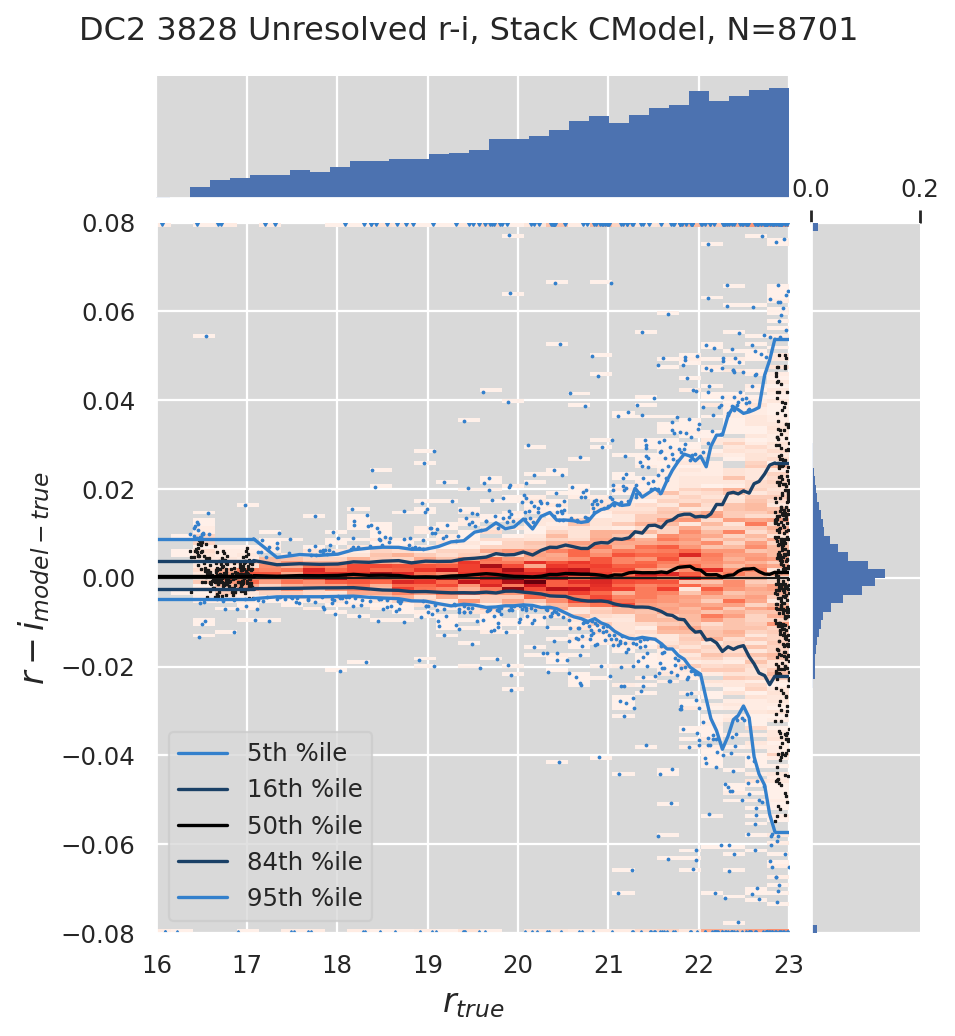

DC2 3828 Unresolved i-z, Stack CModel, N=8732


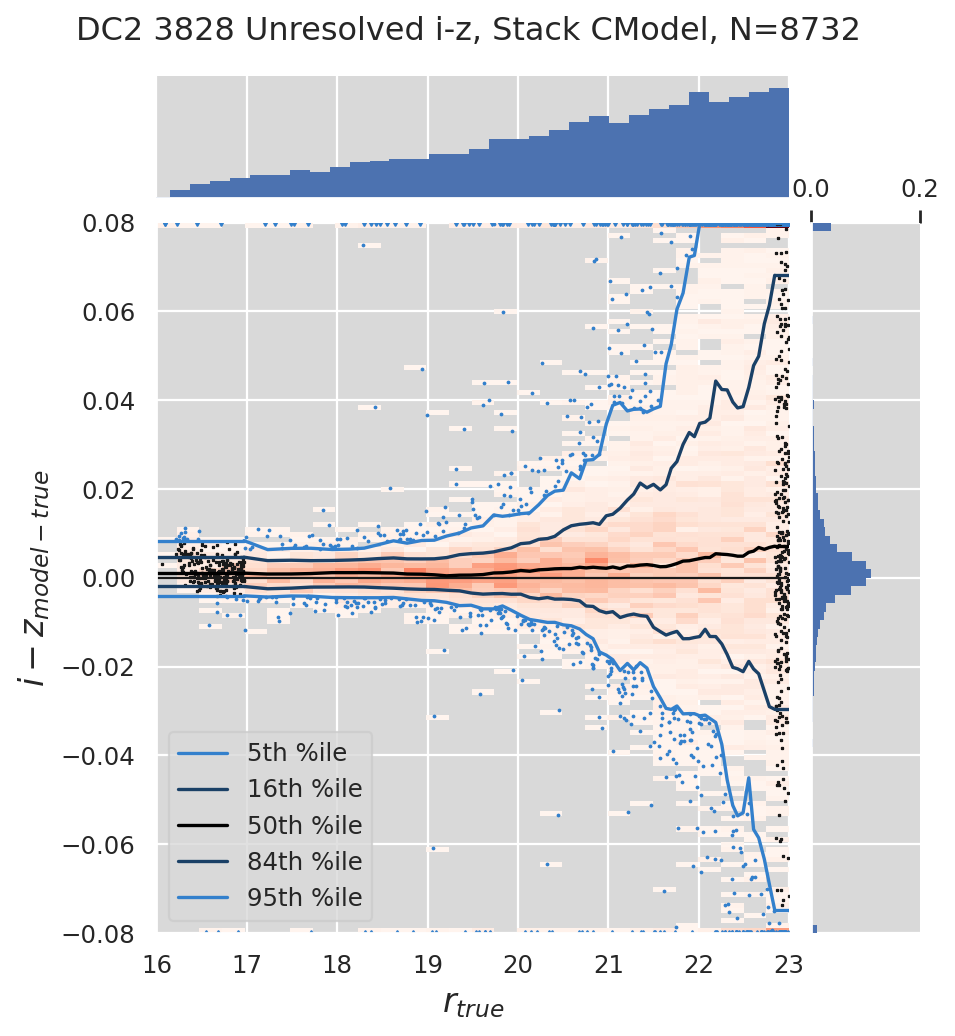

{}

In [9]:
# Stars
plot_matches(
    cats, False, models_stars, filters_single, band_ref=band_ref, band_multi=band_multi,
    band_ref_multi=band_ref, mag_max=23, match_dist_asec=0.168,
    plot_compure=False, rematch=True, **args_type['unresolved'], **args
)

In [14]:
# Compare ngmix vs mpf g-r colours. They agree almost shockingly well for ~80-90% of sources.
band_size = band_multi if band_multi is not None else 'r'
cat_mb = cats[3828]['meas'][band_size]
is_good = cat_mb['detect_isPrimary']
cat_good = cat_mb[is_good]
if get_multiprofit and get_ngmix:
    models_gmr = ['ngmix bd', 'MPF Sersic']
    gmr = {model: models[model].get_color_total(cat_good, 'g', 'r') for model in models_gmr}
    flux = models['ngmix bd'].get_mag_total(cat_good, 'r')
    good = flux < args_type['resolved']['limx'][1]
    for model in models_gmr:
        good &= np.isfinite(gmr[model])
    plotjoint_running_percentiles(
        flux[good],
        gmr['ngmix bd'][good] - gmr['MPF Sersic'][good],
        labelx='$r_{ngmix,bd}$', labely='${g-r}_{ngmix,bd}$ - ${g-r}_{mpf,Sersic}$',
        limx=args_type['resolved']['limx'], limy=(-0.2, 0.2),
        title=f'DC2 3828 All ngmix bd vs MPF Sersic ({band_multi})',
        **args
    )

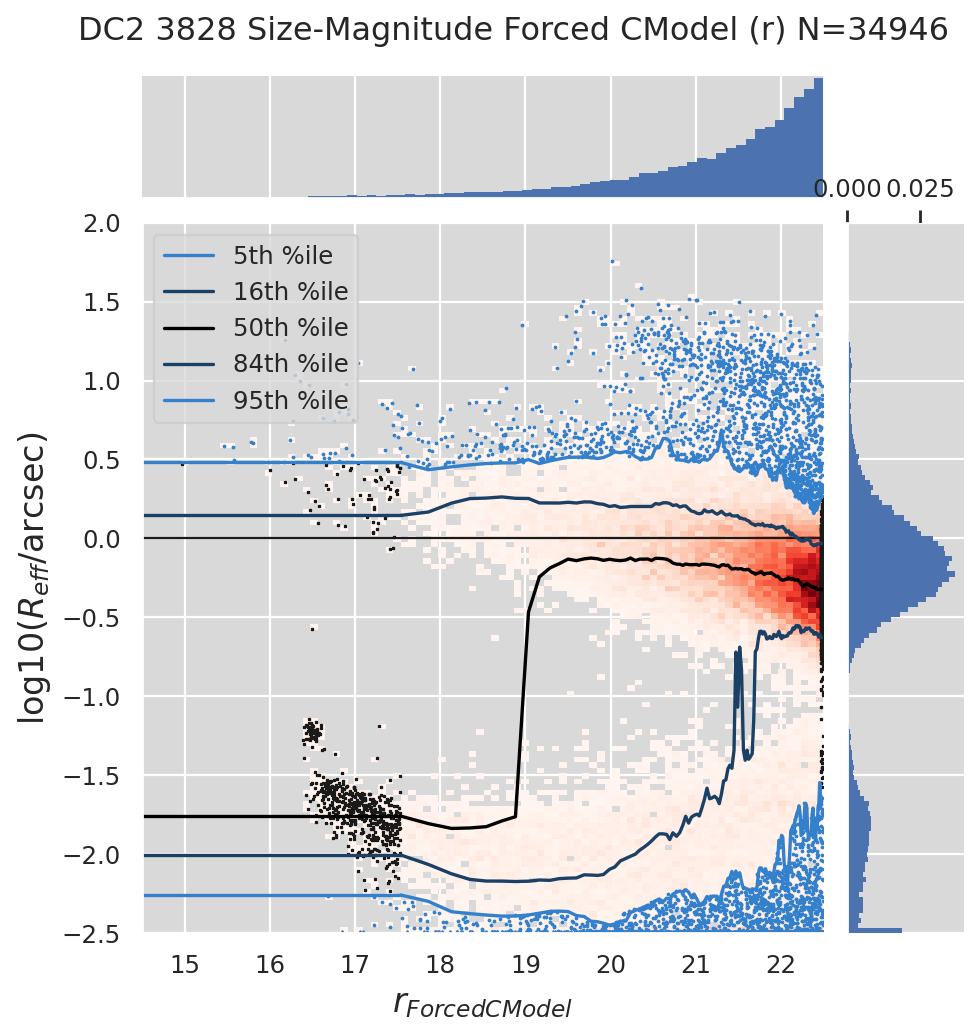

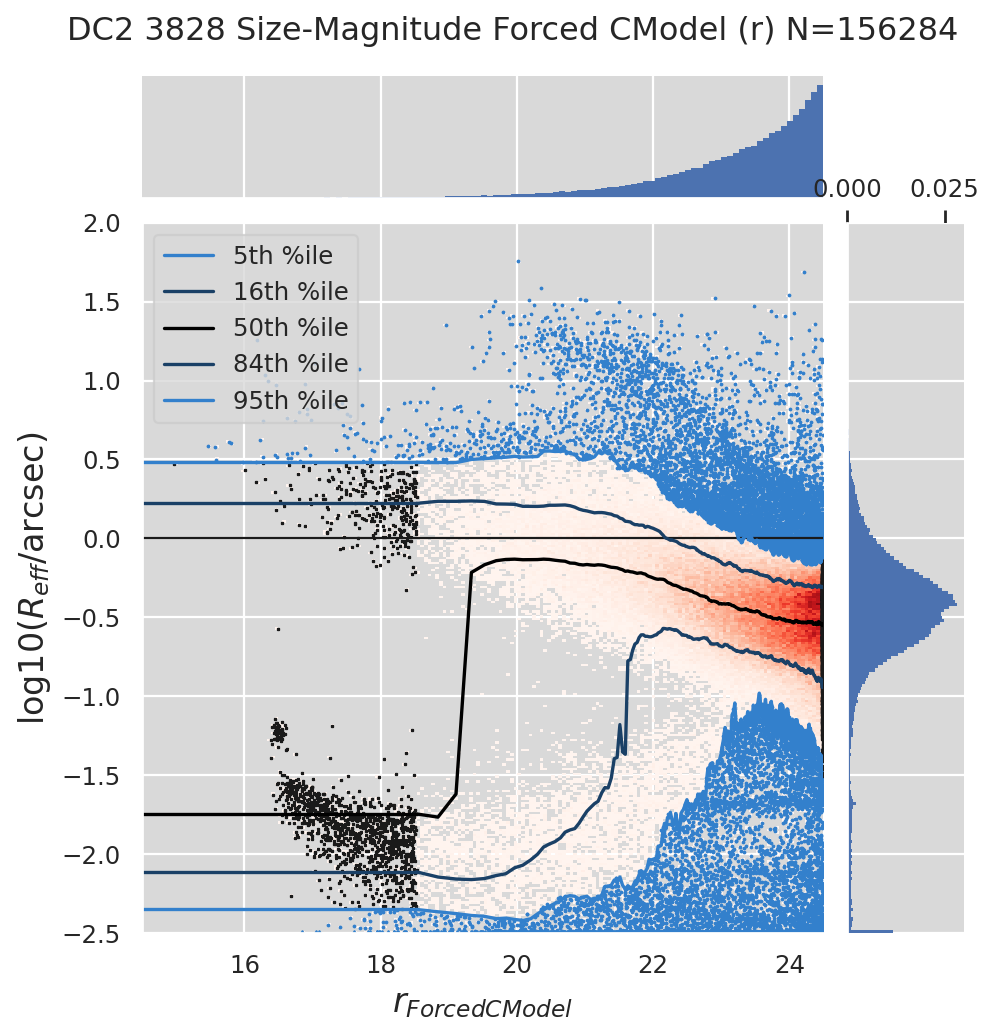

In [15]:
# r-band size mass for all objects
# TODO: Implement getting sizes from model objects
# TODO: Get forced sizes somehow
band = 'r'
scale_pix = 0.2
sizes_model = {}
if get_multiprofit:
    models_plot = ['MPF Gauss', 'MPF Sersic']
    for name_model in models_plot:
        model = models[name_model]
        sizes_model[name_model] = np.log10(
            scale_pix*np.sqrt(0.5*(
                models[model].get_moment2(cat_good, 'x', comp=1)
                + models[model].get_moment2(cat_good, 'y', comp=1)
            ))
        )
if get_cmodel_forced:
    sizes_model['Forced CModel'] = np.log10(
        scale_pix*np.sqrt(0.5*(
            cat_good['modelfit_CModel_ellipse_xx']
            + cat_good['modelfit_CModel_ellipse_yy']
        ))
    )
if get_ngmix:
    sizes_model['ngmix bd'] = np.log10(np.sqrt(0.5*cat_good['ngmix_bd_T']))
mag_min = args_type['resolved']['limx'][0]

for mag_max in (22.5, 24.5):
    for name_model, sizes in sizes_model.items():
        is_ngmix = name_model.startswith('ngmix')
        cat_mag = cat_good if name_model != 'Forced CModel' else cats[3828]['meas'][band][is_good]
        mag = models[name_model].get_mag_total(cat_mag, band)
        good = (mag < mag_max) & np.isfinite(sizes)
        plotjoint_running_percentiles(
            mag[good], sizes[good], limx=(mag_min, mag_max), limy=(-2.5, 2),
            labelx=f'${band}_{{{name_model}}}$',
            labely='log10($R_{eff}$/arcsec)' if not is_ngmix else 'log10($\sigma$/arcsec)',
            title=f'DC2 3828 Size-Magnitude {name_model} ({band_size}) N={np.sum(good)}',
            **args,
        )
        plt.show()

In [16]:
# Timing ngmix and MultiProFit
cat_mb = cats[3828]['meas'][band_multi]
times = {}
if get_multiprofit:
    times['MPF Sersic'] = np.log10(
        cat_mb['multiprofit_gausspx_time'] + cat_mb['multiprofit_mg8expgpx_time']
        + cat_mb['multiprofit_mg8devepx_time'] + cat_mb['multiprofit_mg8serbpx_time']
    )
if get_ngmix:
    times['ngmix bd'] = np.log10(cat_mb['ngmix_time'])

if times:
    model_ref = 'Stack CModel'
    times_ref = None
    bands_done, bands_skipped = 0, 0
    for band in band_multi:
        cat = cats[3828]['meas'].get(band)
        if cat is not None:
            times_cm = cat['modelfit_CModel_exp_time'] + cat['modelfit_CModel_dev_time'] + cat['modelfit_CModel_initial_time']
            if times_ref is None:
                times_ref = times_cm
            else:
                times_ref += times_cm
            bands_done += 1
        else:
            bands_skipped += 1
    times_ref *= (bands_skipped + bands_done)/bands_done

    lim_time = (-2.2, 1.8)
    lim_y = (-2.1, 4.1)

    # Anything more than 1 dex lower than the lower plot limit is probably wrong
    times[model_ref] = np.clip(np.log10(times_ref), lim_time[0]-1, lim_time[1])

    # ha ha, how negative
    good_times = None
    for times_model in times.values():
        good_time = (times_model > lim_time[0])
        if good_times is None:
            good_times = good_time
        else:
            good_times &= good_time

    times_ref = times[model_ref][good_times]
    for model, times_model in times.items():
        print(f'{model} t_total={np.sum(10**times_model[good_times])}')
        if model != model_ref:
            plotjoint_running_percentiles(
                times_ref, times_model[good_times] - times_ref,
                limx=lim_time, limy=lim_y,
                labelx='log10($t_{cmodel}$)', labely=f'log10($t_{{{model}}}/t_{{{model_ref}}}$)',
                title=f'DC2 3828 All Timing {model} vs {model_ref} ({band_multi})',
                **args,
            )
            plt.show()

KeyError: None